In [64]:
from typing import List, Optional, NamedTuple, Literal

import collections
import itertools
import functools
import json
import math
import os
import sys
import pathlib
import datetime
import hashlib

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import random

In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [6]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [7]:
mpl.rcParams["figure.figsize"] = (10, 8)

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [33]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [34]:
ds_processed.obs.cell_type = ds_processed.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2 mature',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [35]:
rng = np.random.default_rng(seed=101)
ds_processed.uns['cell_type_colors'] = list(rng.permutation(
    ds_processed.uns['cell_type_colors']
))

In [36]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [37]:
ds = ds_processed

In [38]:
ds

AnnData object with n_obs × n_vars = 197208 × 1000
    obs: 'Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status', 'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type', 'Tissue location', 'Additional data', 'Chemistry', 'Fastq', 'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type'
    var: 'feature_types', 'n_counts', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', 'cell_type_colors', 'hvg', 'leiden', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# 1. Myeloid object excluding DCs PAGA and Diffusion componets

Let's exclude DCs

In [39]:
myeloid = ds[ds.obs.cell_type.str.contains("TRAM|MoAM|macrophage|Mono", regex=True)]

In [40]:
myeloid = myeloid[myeloid.obs.cell_type.ne('Proliferating macrophages'), :].copy()

In [41]:
sc.pp.neighbors(myeloid, use_rep='X_scVI')

In [42]:
sc.tl.paga(myeloid, groups="cell_type")

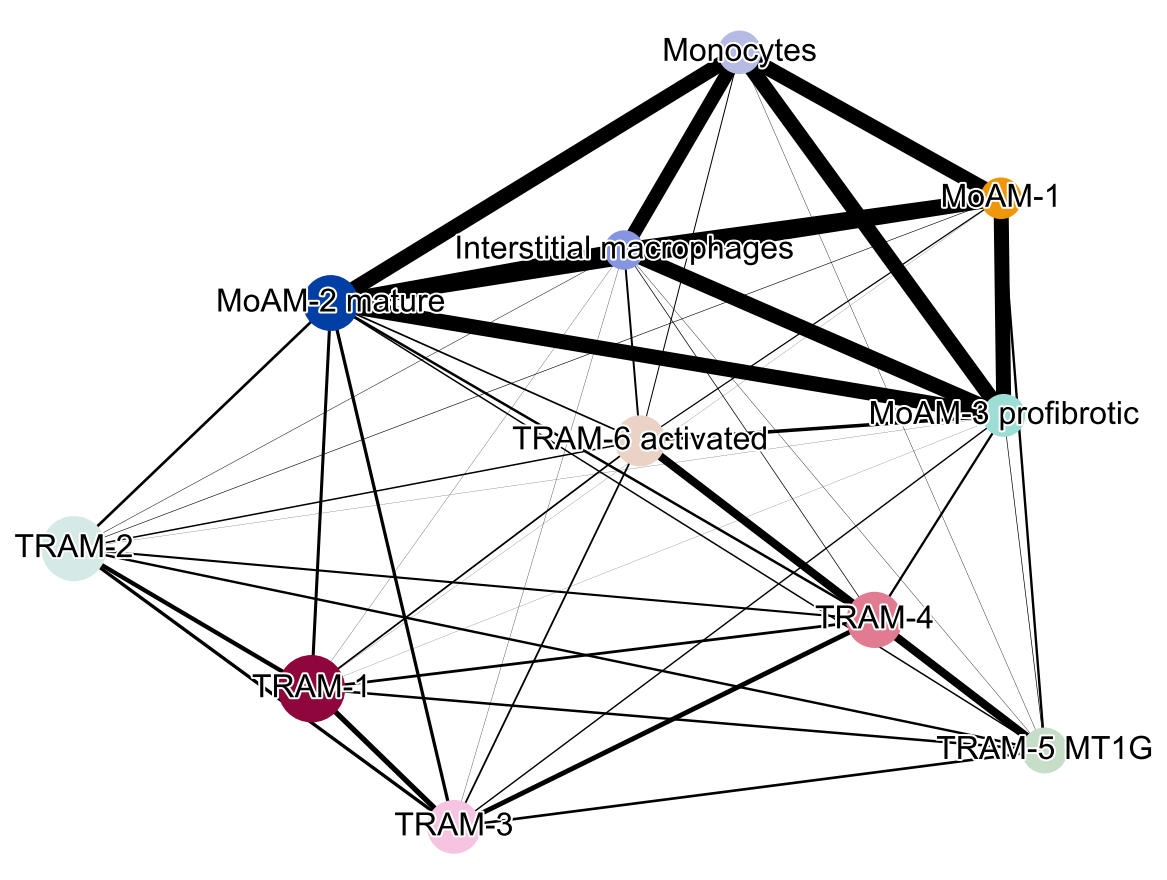

In [92]:
# only this works. options to paga don't work. Ugh
random.seed(100)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sc.pl.paga(
    myeloid, 
    fontoutline=2, 
    layout='drl', 
    node_size_scale=4,
    fontsize=16,
    text_kwds=dict(
        weight='normal'
    ),
    ax=ax,
    frameon=False
)
fig.savefig('00_figures/Figure_5A_paga.pdf')

PAGA connects MoAMs, monocytes and Perivascular macrophages much more than TRAMs, which is unexpected. It means that there's more separation between TRAM subsets than between MoAM subsets

In [93]:
sc.tl.diffmap(myeloid)

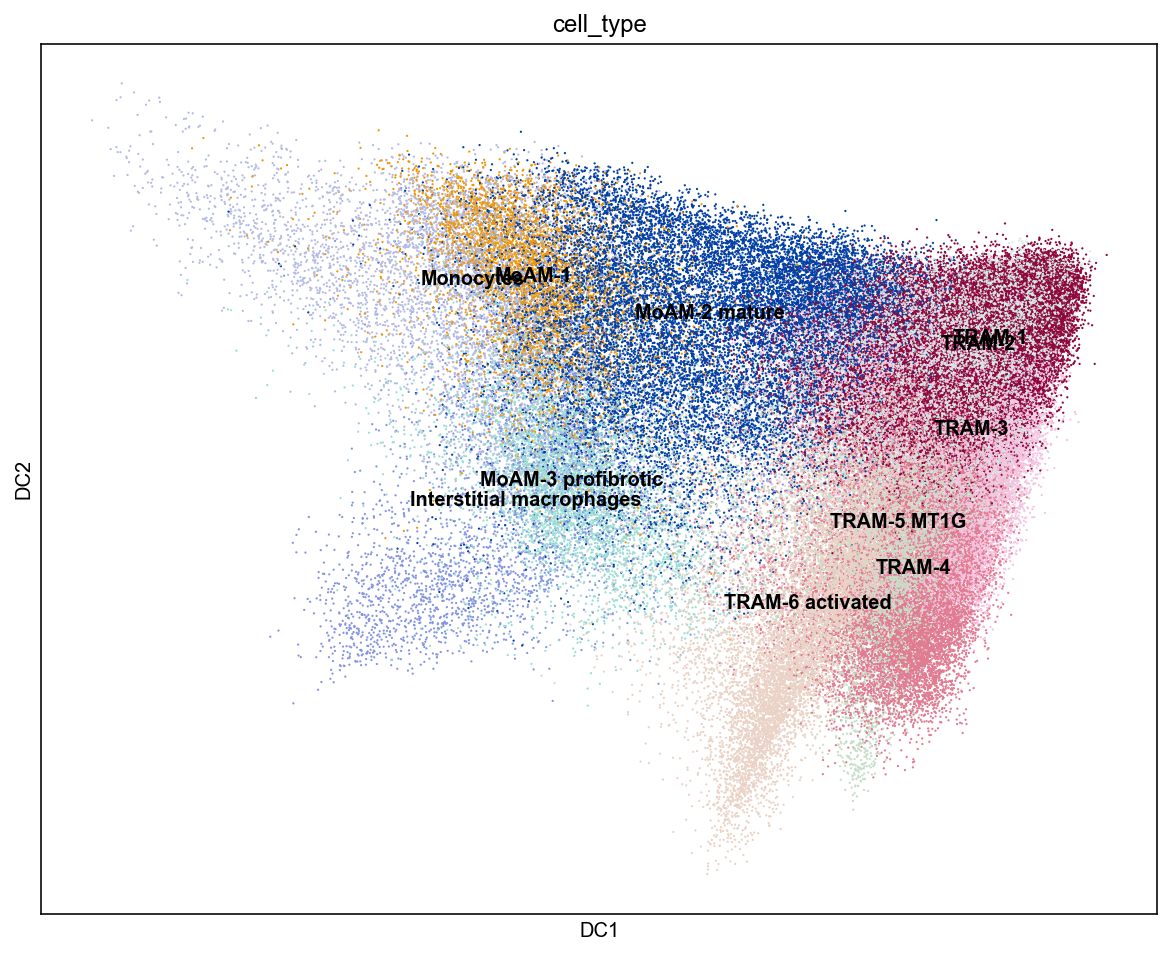

In [94]:
sc.pl.diffmap(myeloid, color=["cell_type"], components=(1, 2), size=5, legend_loc="on data")

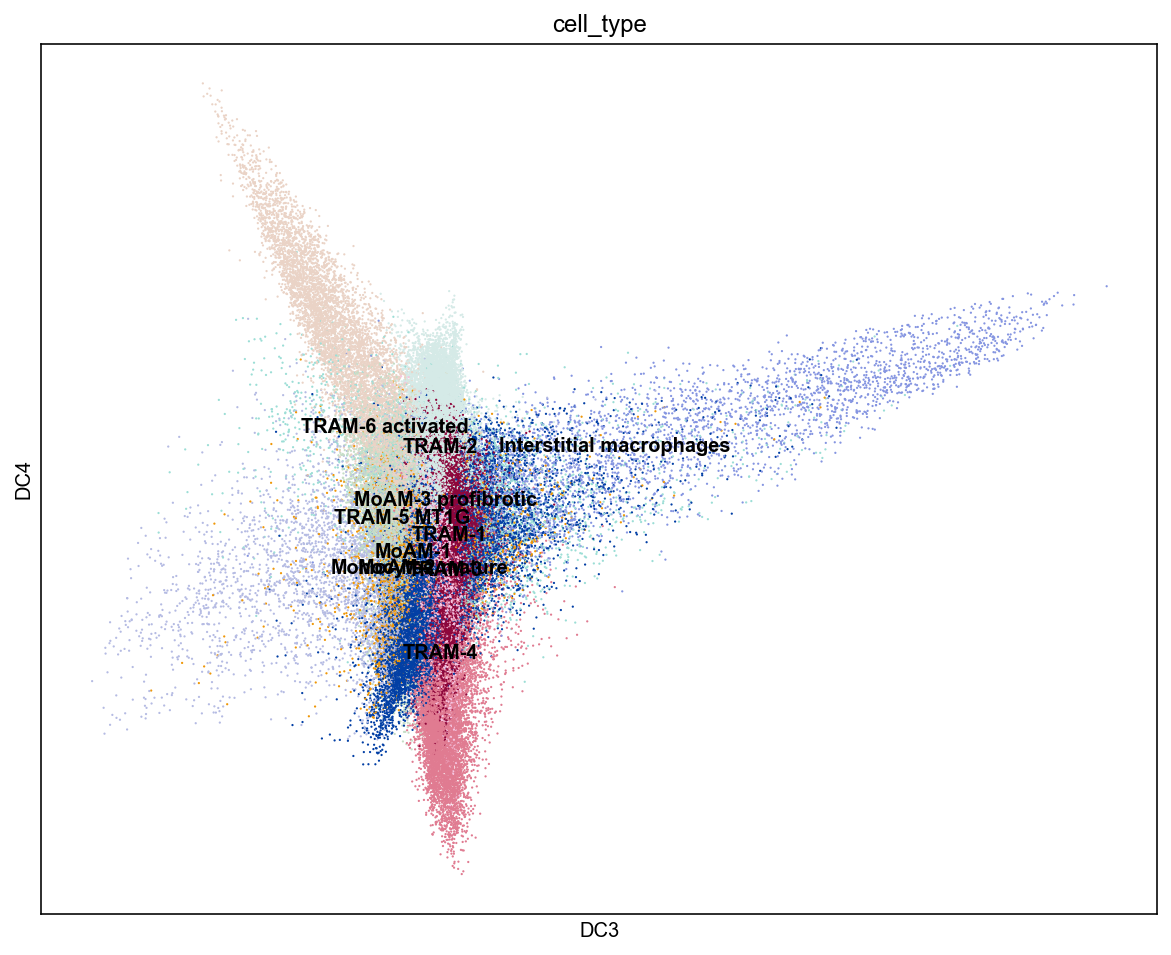

In [95]:
sc.pl.diffmap(myeloid, color=["cell_type"], components=(3, 4), size=5, legend_loc="on data")

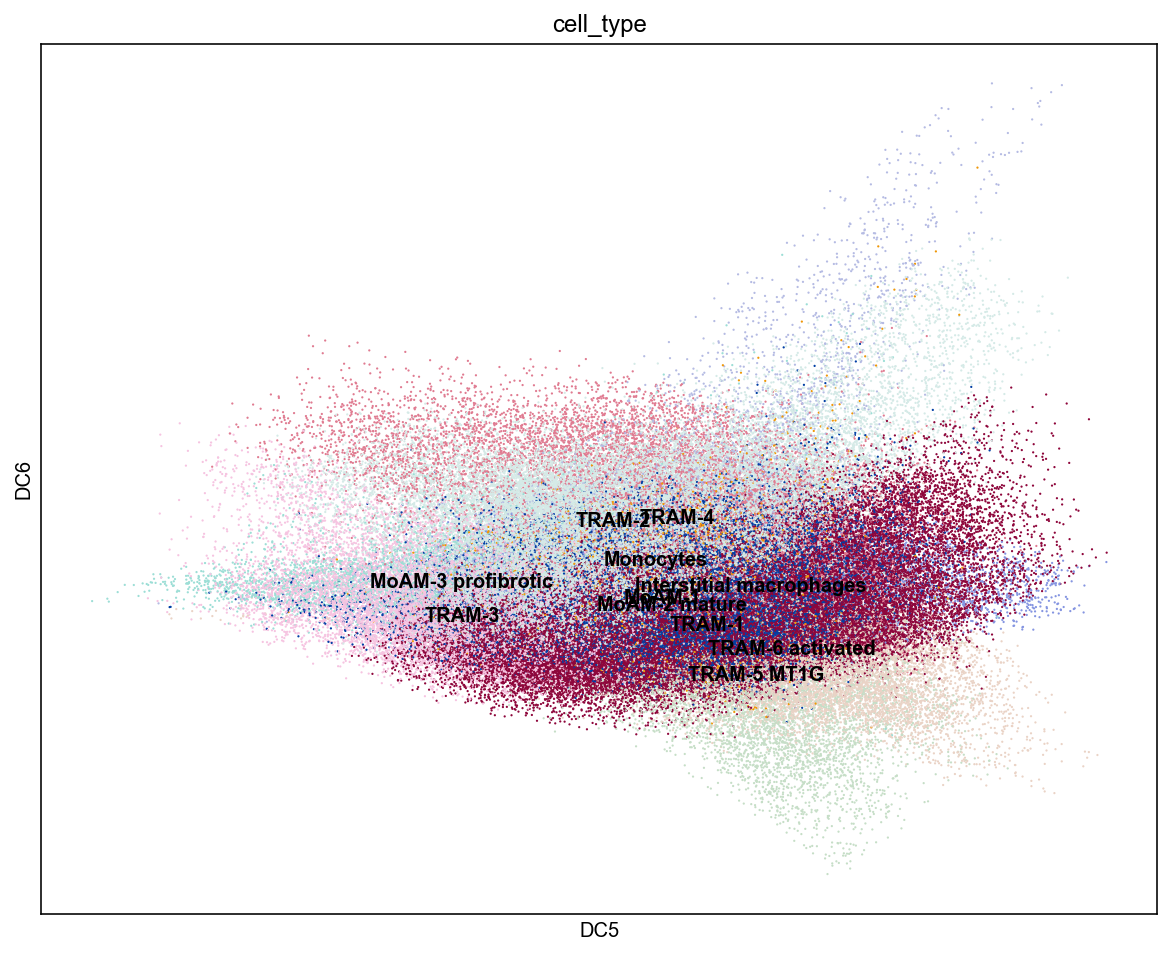

In [96]:
sc.pl.diffmap(myeloid, color=["cell_type"], components=(5, 6), size=5, legend_loc="on data")

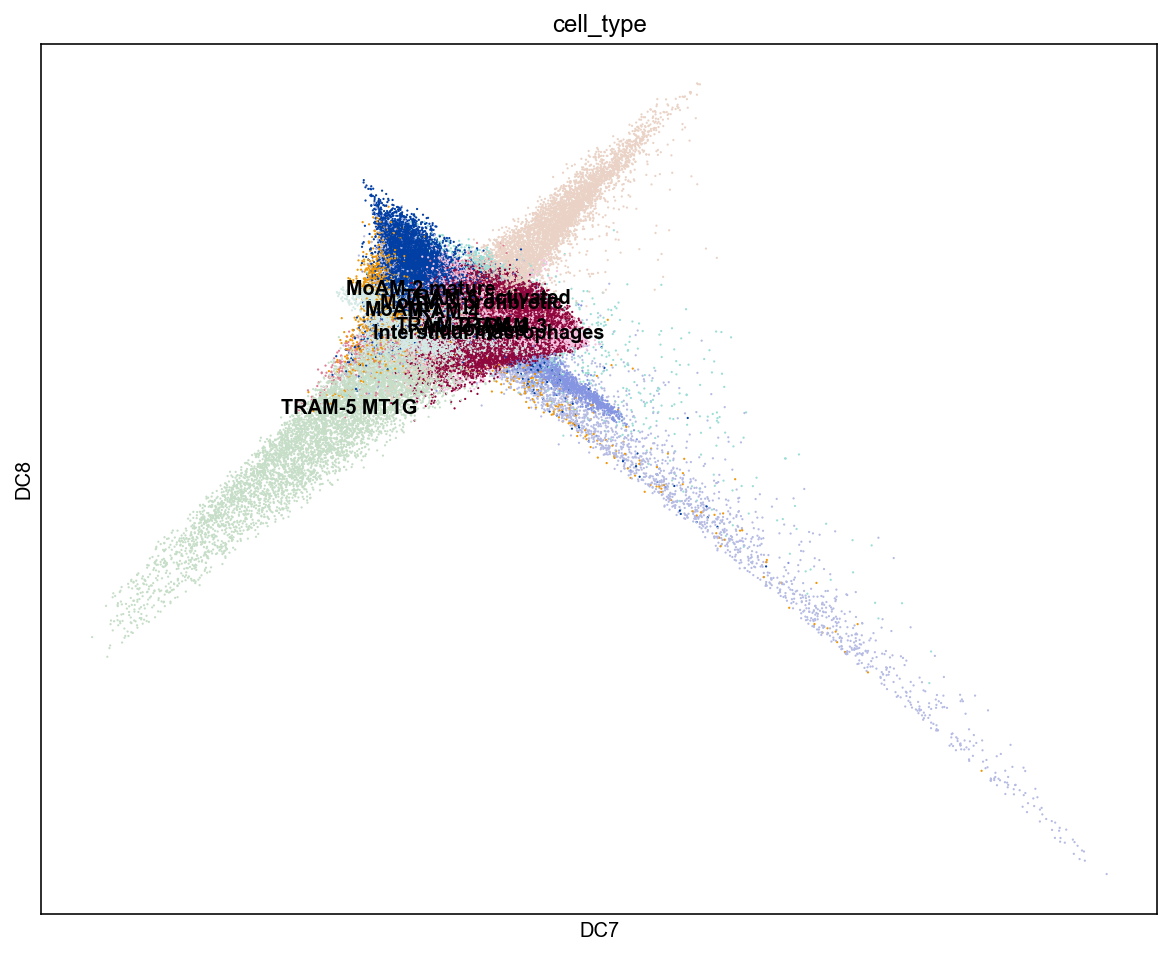

In [97]:
sc.pl.diffmap(myeloid, color=["cell_type"], components=(7, 8), size=5, legend_loc="on data")

Diffusion components are not straightforward, especially 1 & 2

DC1 seems to be Monocyte to TRAM differentiation, while DC2 seems to be a sort of activation.

# 2. Myeloid component without DCs: composition

By study

<AxesSubplot:title={'center':'Cell_type by Study'}>

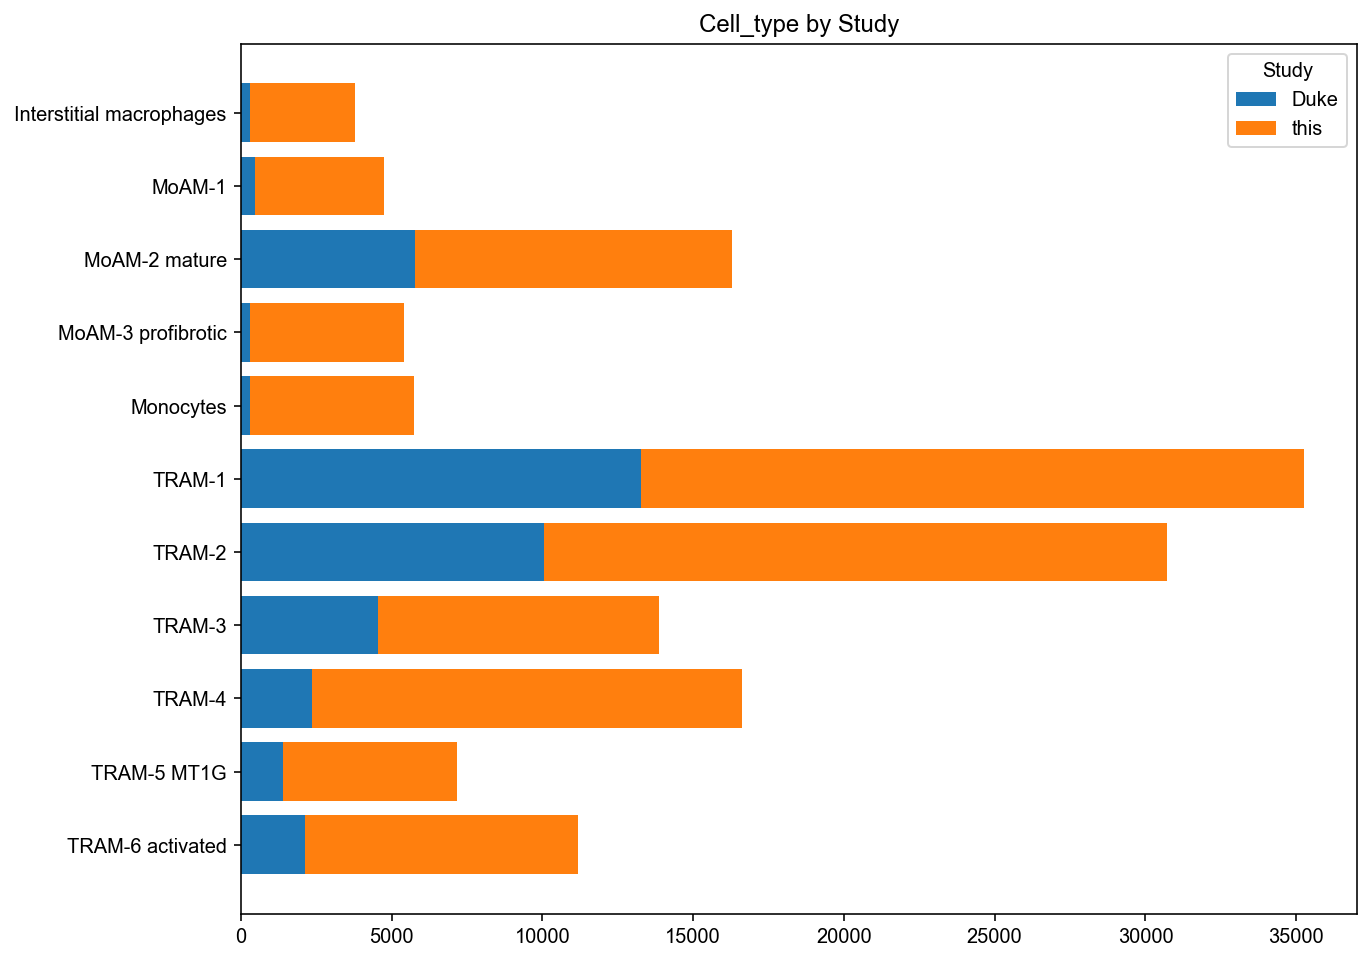

In [98]:
sc_utils.plot_composition(myeloid, group_by="cell_type", color="Study")

By disease status

<AxesSubplot:title={'center':'Cell_type by Status'}>

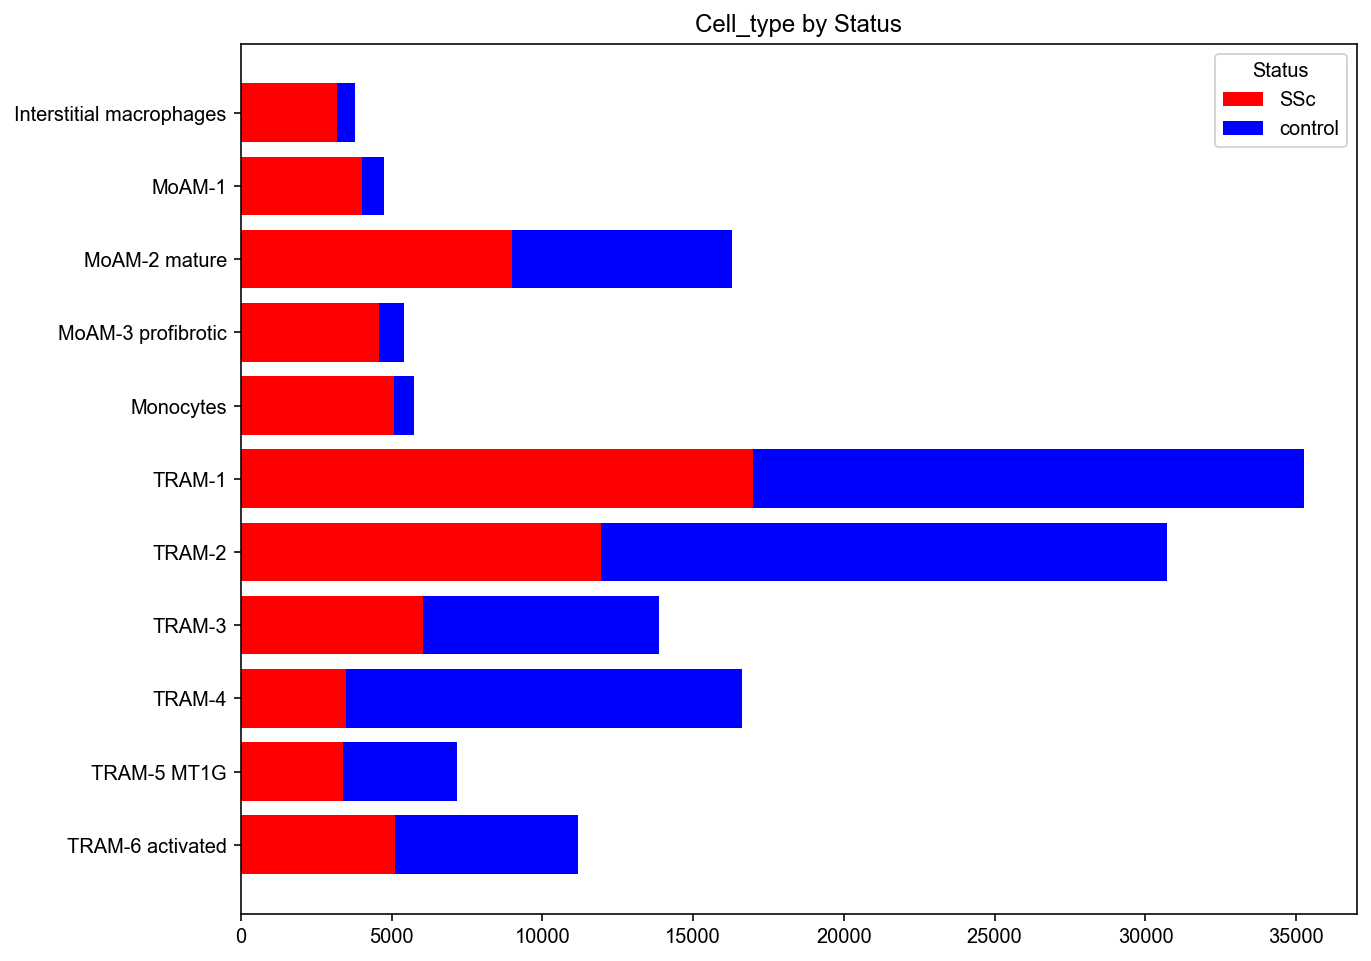

In [99]:
sc_utils.plot_composition(myeloid, group_by="cell_type", color="Status", palette=["red", "blue"])

By Patient

<AxesSubplot:title={'center':'Cell_type by Patient'}>

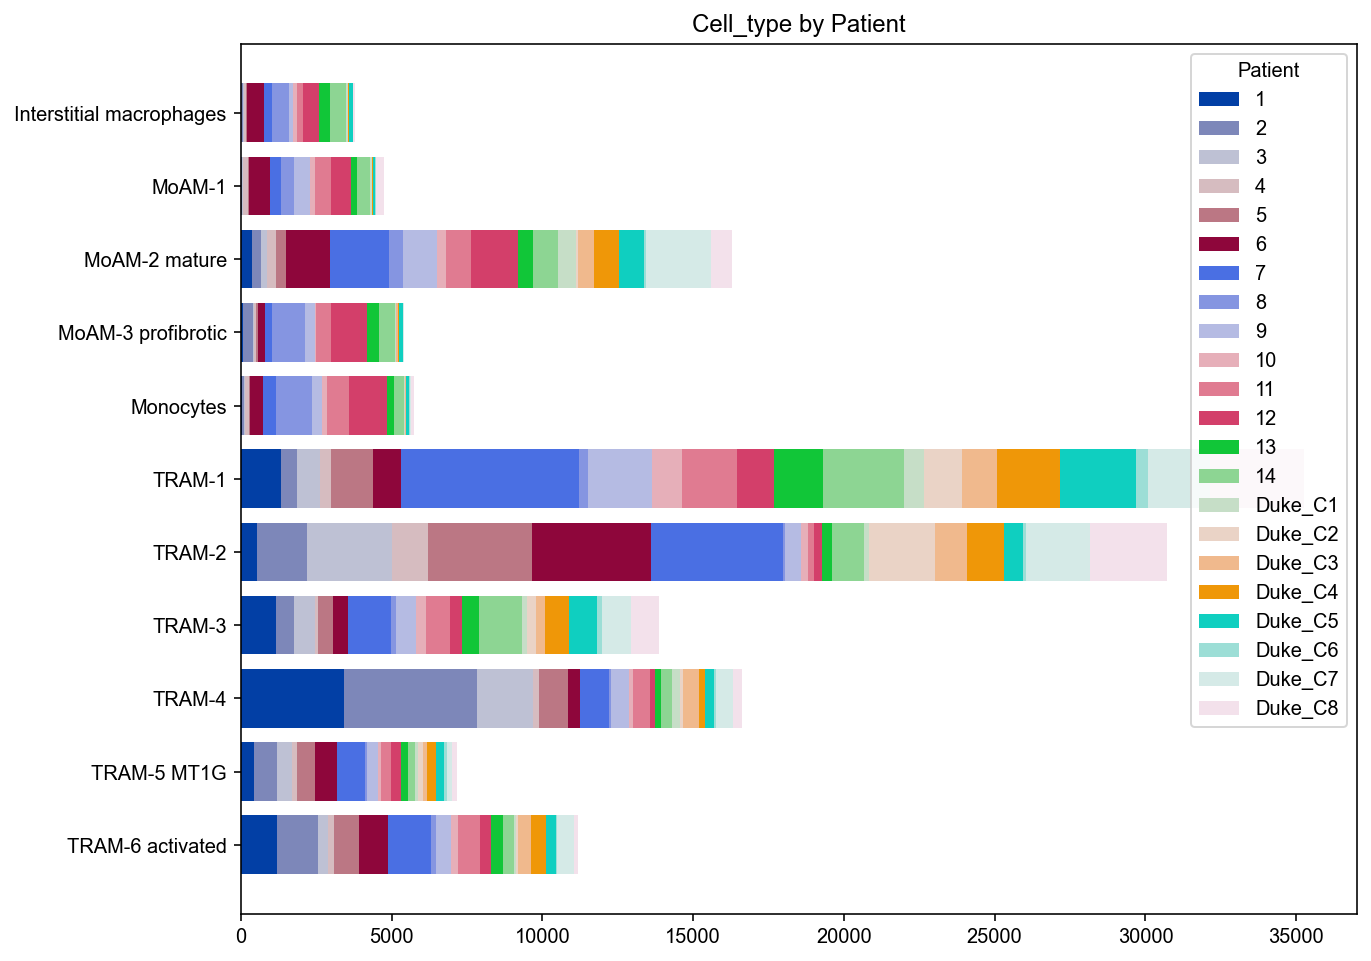

In [100]:
sc_utils.plot_composition(myeloid, group_by="cell_type", color="Patient")

# 3. Diffences in PAGA connectivity between HC and SSc

## 3.1 Myeloid without DCs in Healthy controls

In [101]:
myeloid_hc = myeloid[myeloid.obs.Status.eq("control"), :].copy()

In [102]:
del myeloid_hc.uns["paga"]

Recompute neighbors. This should not change PAGA

In [103]:
sc.pp.neighbors(myeloid_hc, use_rep="X_scVI")

In [104]:
sc.tl.paga(myeloid_hc, groups="cell_type")

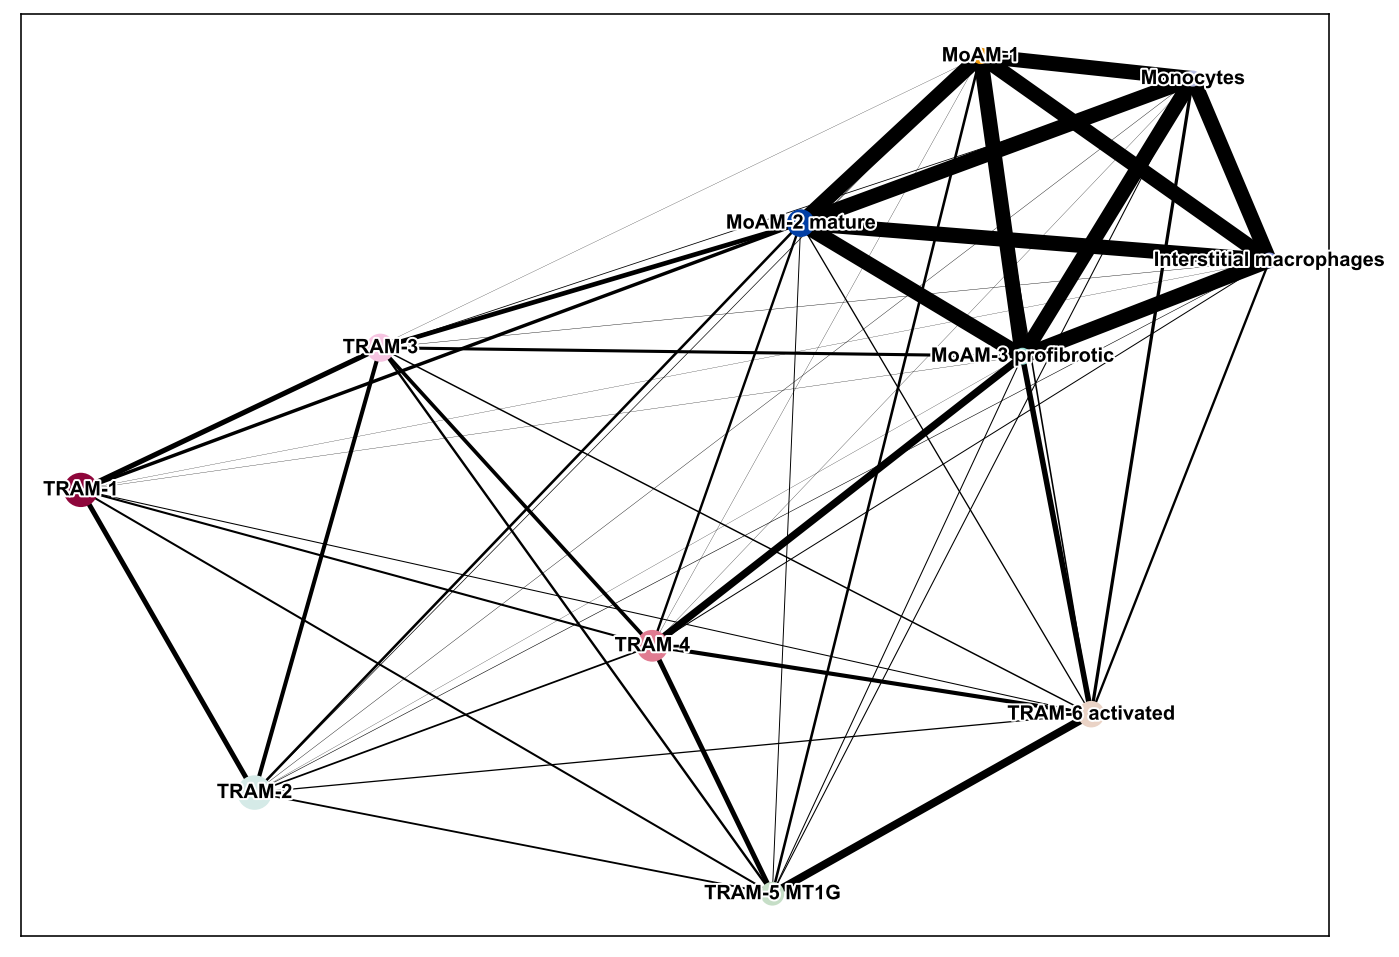

In [105]:
sc.pl.paga(myeloid_hc, fontoutline=2)

## 3.2 Myeloid without DCs in SSc

In [106]:
myeloid_ssc = myeloid[myeloid.obs.Status.eq("SSc"), :].copy()

In [107]:
del myeloid_ssc.uns["paga"]

In [108]:
sc.pp.neighbors(myeloid_ssc, use_rep="X_scVI")

In [109]:
sc.tl.paga(myeloid_ssc, groups="cell_type")

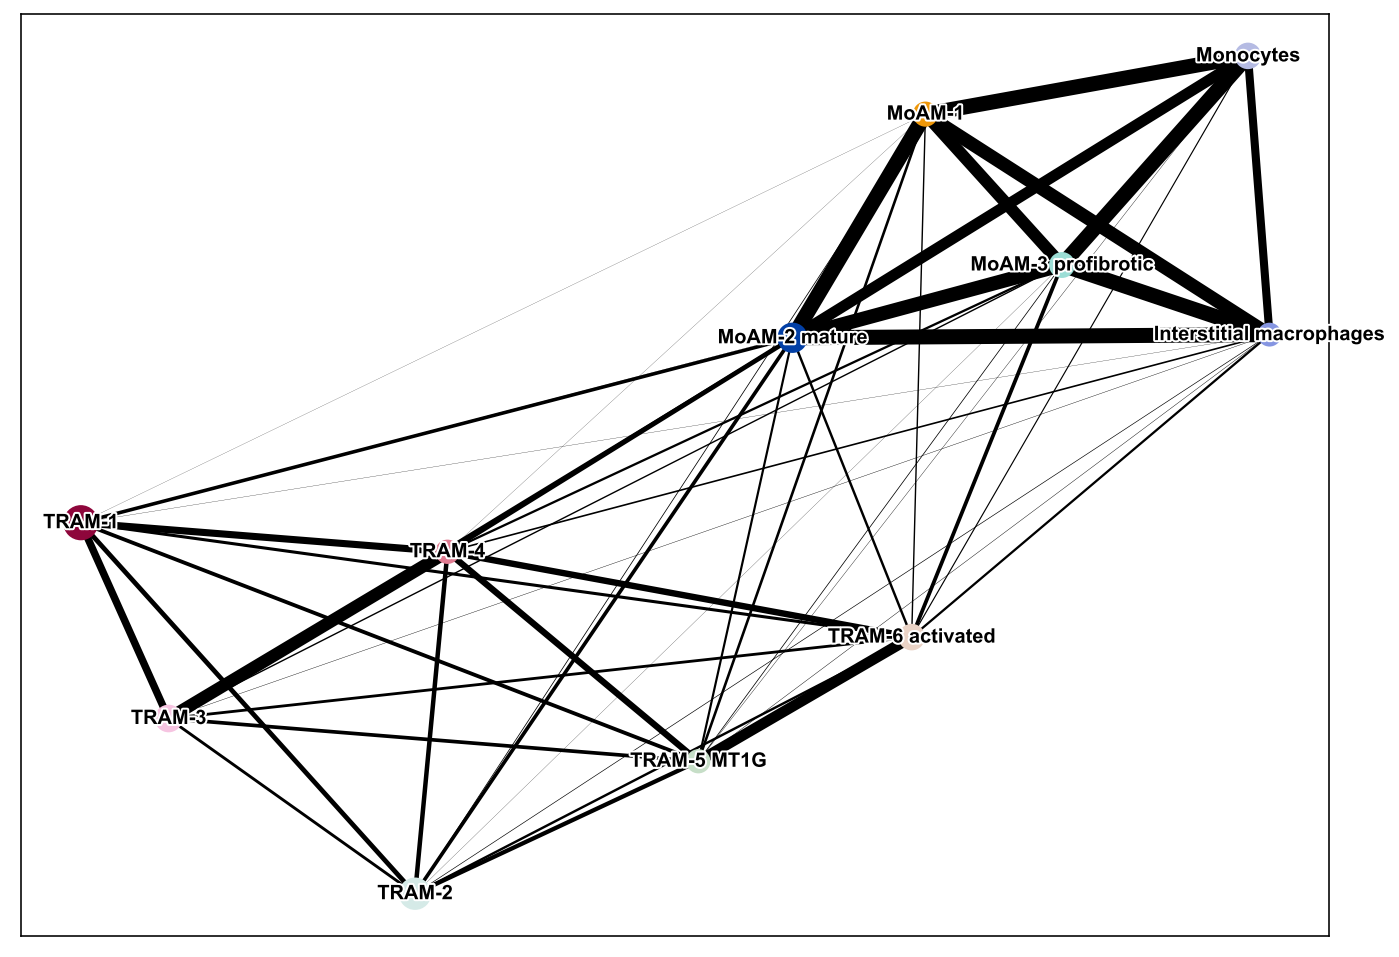

In [110]:
sc.pl.paga(myeloid_ssc, fontoutline=2)

## 3.3 Transition map for HC

In [112]:
myeloid_order = [
    'Monocytes', 'MoAM-1', 'MoAM-2 mature', 'MoAM-3 profibrotic', 
    'Interstitial macrophages', 'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 
    'TRAM-5 MT1G', 'TRAM-6 activated'
]

<AxesSubplot:>

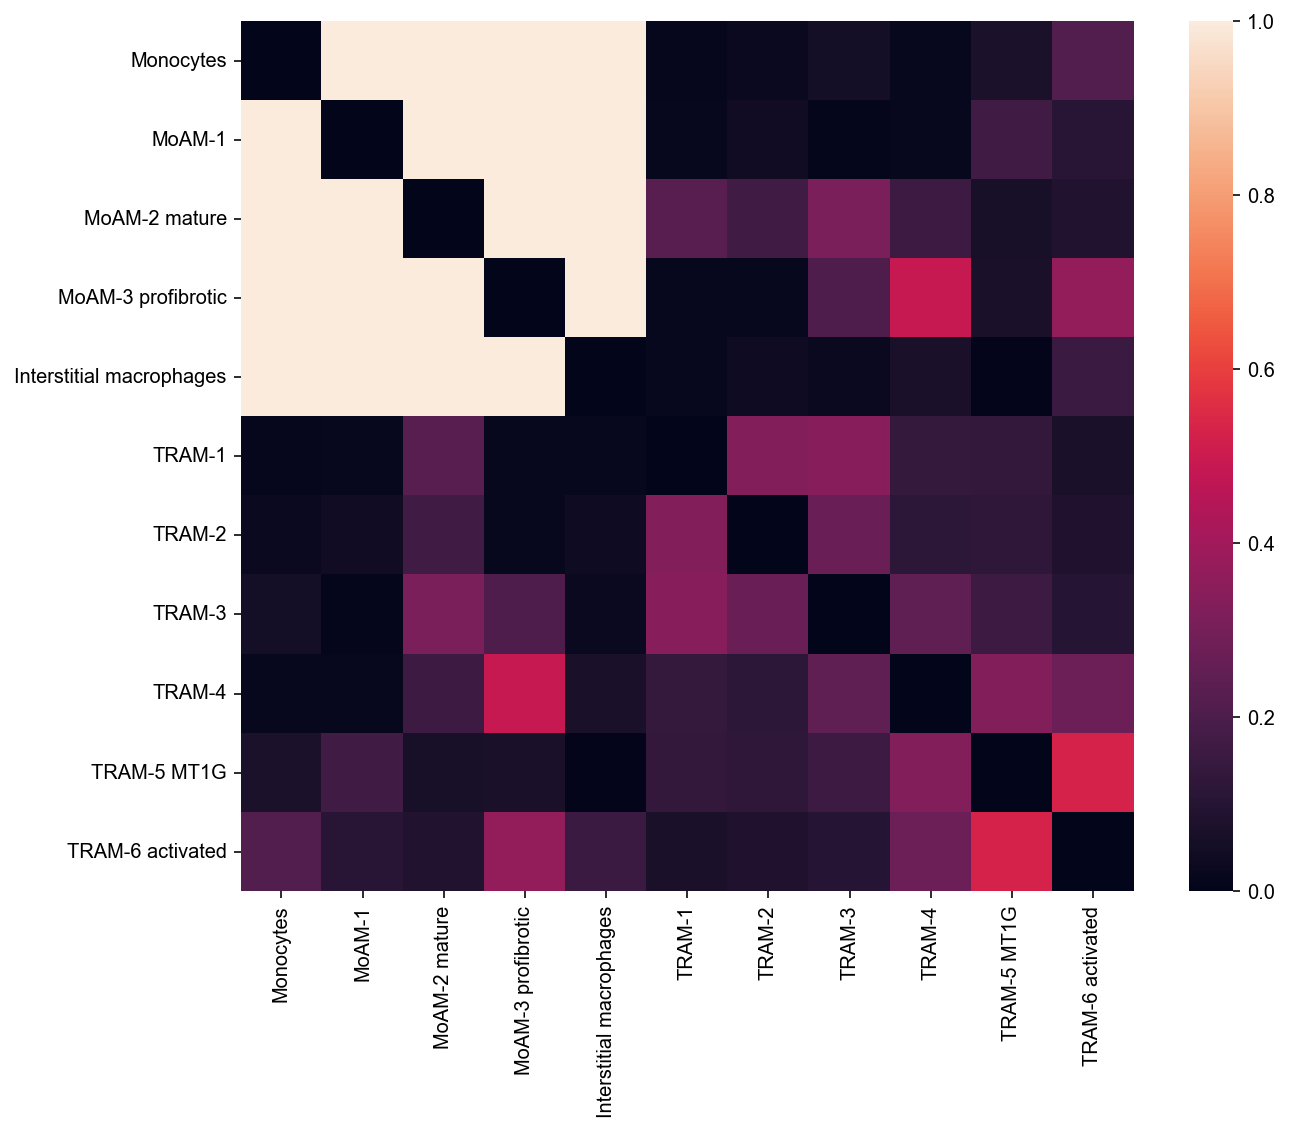

In [113]:
sns.heatmap(
    pd.DataFrame(
        myeloid_hc.uns["paga"]["connectivities"].todense(),
        index=myeloid_hc.obs.cell_type.cat.categories,
        columns=myeloid_hc.obs.cell_type.cat.categories,
    ).loc[myeloid_order, myeloid_order]
)

## 3.4 Transition map for SSc

<AxesSubplot:>

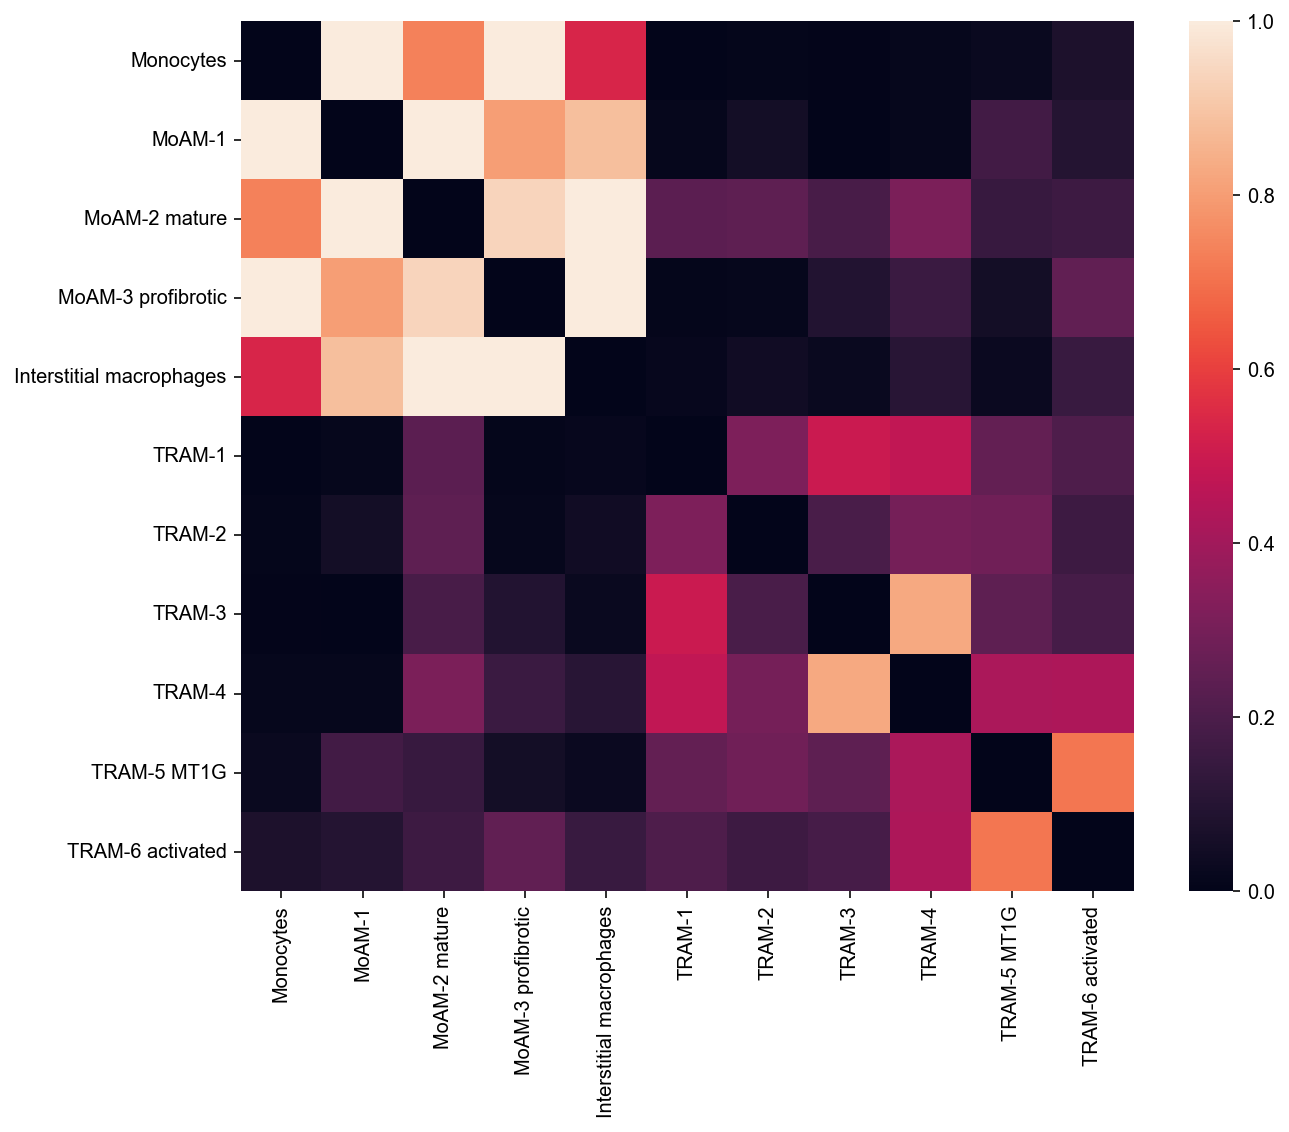

In [114]:
sns.heatmap(
    pd.DataFrame(
        myeloid_ssc.uns["paga"]["connectivities"].todense(),
        index=myeloid_ssc.obs.cell_type.cat.categories,
        columns=myeloid_ssc.obs.cell_type.cat.categories,
    ).loc[myeloid_order, myeloid_order]
)

## 3.5 Combined transition map

In [115]:
healthy_df = pd.DataFrame(
    myeloid_hc.uns["paga"]["connectivities"].todense(),
    index=myeloid_hc.obs.cell_type.cat.categories,
    columns=myeloid_hc.obs.cell_type.cat.categories,
).loc[myeloid_order, myeloid_order]

In [116]:
ssc_df = pd.DataFrame(
    myeloid_ssc.uns["paga"]["connectivities"].todense(),
    index=myeloid_ssc.obs.cell_type.cat.categories,
    columns=myeloid_ssc.obs.cell_type.cat.categories,
).loc[myeloid_order, myeloid_order]

In [117]:
all_df = healthy_df.where(np.triu(np.ones(healthy_df.shape)).astype(bool), other=ssc_df)

Combine the 2 heatmaps into one: upper triangle is Health, lower triangle is SSc

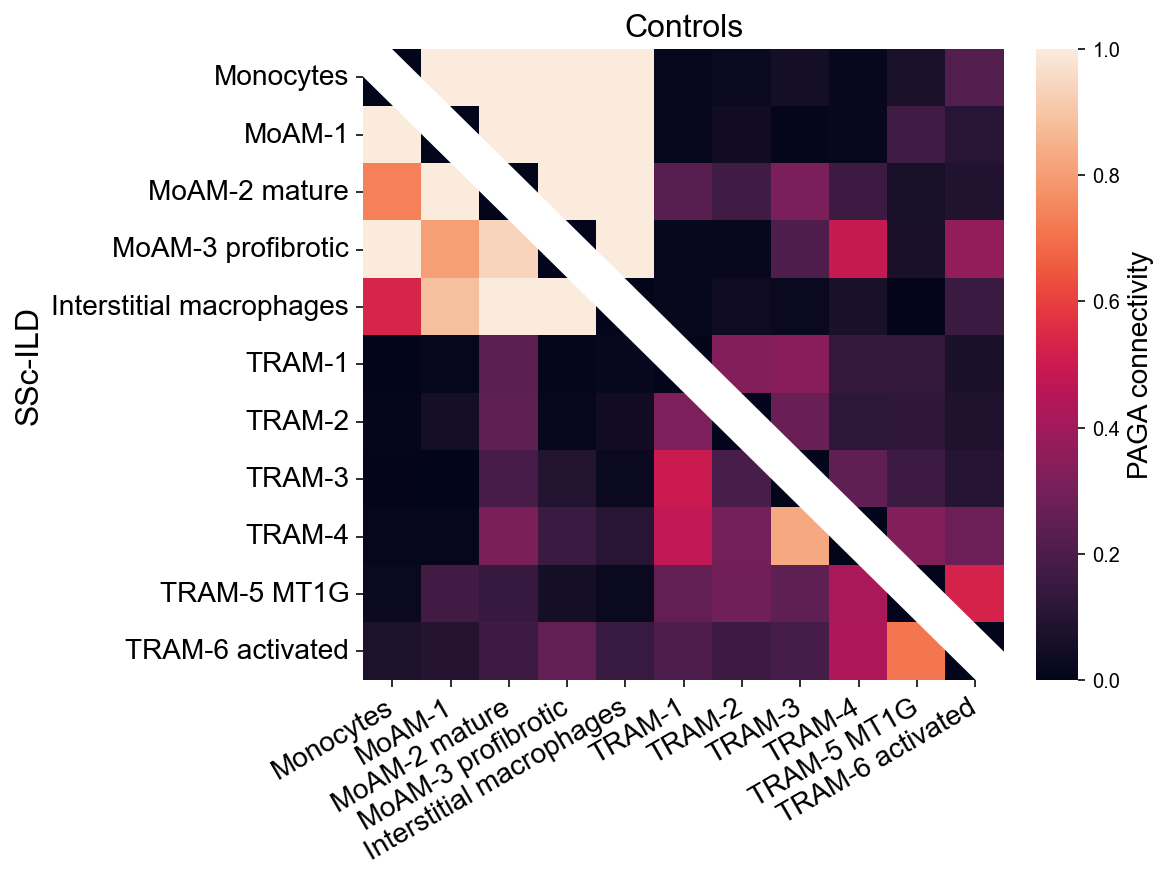

In [125]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sns.heatmap(
    all_df, 
    ax=ax, 
    cbar_kws={
        "label": "PAGA connectivity",
    }
)
ax.set_title("Controls", fontsize=16)
ax.set_ylabel("SSc-ILD", size=16)
ax.tick_params(labelsize=14)
ax.tick_params(axis="x", rotation=30)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.xaxis.get_ticklabels():
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)
ax.axline((ax.get_xlim()[0], ax.get_ylim()[1]), slope=1, c="white", lw=20);
fig.axes[1].set_ylabel('PAGA connectivity', size=14)
fig.savefig('00_figures/Figure_5B_paga_heatmap.pdf')

**Results**:

In Healthy controls
1. Monocytes are maximally related to all MoAMs and Perivascular macrophages.
2. MoAM-3 mature are most related to all TRAMs
3. MoAM-4 profibrotic are related to TRAM-6 activated and TRAM-4
4. Perivascular macrophages are related to TRAM-6 activated, but no other TRAMs

In SSc
1. Monocytes are maximally related to MoAM-1 and MoAM-4 profibrotic, but not to MoAM-3 mature, and not to Perivascular macrophages
2. Perivascular macrophages are maximally related to MoAM-3 mature and MoAM-4 profibrotic
3. MoAM-3 mature are most related to all TRAMs
4. MoAM-4 profibrotic are related to TRAM-6 activated

**Conclusions**:
1. Relationship between Monocytes, MoAMs and Perivascular macrophages seems to be changed between HC and SSc
2. In particular, MoAM-3 and Perivascular macrophages are less similar to Monocytes in SSc compared to HC
3. Out of all MoAMs or Perivascular macrophages only MoAM-3 seem to give rise to TRAMs across both HC and SSc
4. The previous item suggests that MoAM-4 and Perivascular macrophages are separate trajectories from MoAM-3 → TRAM path
5. MoAM-4 profibrotic relationship to TRAM-6 activated is probably due to activated markers expression (CCL3, CCL4, CXCL10 etc.)

## 3.6 Modify PAGA to get resolution for high-connected clusters

Because PAGA above clips close relationships between clusters at `1` connectivity maximum, it is impossible to tell differences between MoAM interrelationship from this.

I remove the maximum clipping, to inspect the unclipped PAGA connectivity

In [51]:
def paga(
    adata: ad.AnnData,
    groups: Optional[str] = None,
    use_rna_velocity: bool = False,
    model: Literal['v1.2', 'v1.0'] = 'v1.2',
    neighbors_key: Optional[str] = None,
    copy: bool = False,
):
    from scanpy import _utils
    from scanpy import logging as logg
    
    check_neighbors = 'neighbors' if neighbors_key is None else neighbors_key
    if check_neighbors not in adata.uns:
        raise ValueError(
            'You need to run `pp.neighbors` first to compute a neighborhood graph.'
        )
    if groups is None:
        for k in ("leiden", "louvain"):
            if k in adata.obs.columns:
                groups = k
                break
    if groups is None:
        raise ValueError(
            'You need to run `tl.leiden` or `tl.louvain` to compute '
            "community labels, or specify `groups='an_existing_key'`"
        )
    elif groups not in adata.obs.columns:
        raise KeyError(f'`groups` key {groups!r} not found in `adata.obs`.')

    adata = adata.copy() if copy else adata
    _utils.sanitize_anndata(adata)
    start = logg.info('running PAGA')
    paga = PAGA(adata, groups, model=model, neighbors_key=neighbors_key)
    # only add if not present
    if 'paga' not in adata.uns:
        adata.uns['paga'] = {}
    if not use_rna_velocity:
        paga.compute_connectivities()
        adata.uns['paga']['connectivities'] = paga.connectivities
        adata.uns['paga']['connectivities_tree'] = paga.connectivities_tree
        # adata.uns['paga']['expected_n_edges_random'] = paga.expected_n_edges_random
        adata.uns[groups + '_sizes'] = np.array(paga.ns)
    else:
        paga.compute_transitions()
        adata.uns['paga']['transitions_confidence'] = paga.transitions_confidence
        # adata.uns['paga']['transitions_ttest'] = paga.transitions_ttest
    adata.uns['paga']['groups'] = groups
    logg.info(
        '    finished',
        time=start,
        deep='added\n'
        + (
            "    'paga/transitions_confidence', connectivities adjacency (adata.uns)"
            # "    'paga/transitions_ttest', t-test on transitions (adata.uns)"
            if use_rna_velocity
            else "    'paga/connectivities', connectivities adjacency (adata.uns)\n"
            "    'paga/connectivities_tree', connectivities subtree (adata.uns)"
        ),
    )
    return adata if copy else None


In [52]:
class PAGA:
    def __init__(self, adata, groups, model='v1.2', neighbors_key=None):
        from scanpy.neighbors import Neighbors
        
        assert groups in adata.obs.columns
        self._adata = adata
        self._neighbors = Neighbors(adata, neighbors_key=neighbors_key)
        self._model = model
        self._groups_key = groups

    def compute_connectivities(self):
        if self._model == 'v1.2':
            return self._compute_connectivities_v1_2()
        elif self._model == 'v1.0':
            return self._compute_connectivities_v1_0()
        else:
            raise ValueError(
                f'`model` {self._model} needs to be one of {_AVAIL_MODELS}.'
            )

    def _compute_connectivities_v1_2(self):
        import igraph
        from scanpy import _utils

        ones = self._neighbors.distances.copy()
        ones.data = np.ones(len(ones.data))
        # should be directed if we deal with distances
        g = _utils.get_igraph_from_adjacency(ones, directed=True)
        vc = igraph.VertexClustering(
            g, membership=self._adata.obs[self._groups_key].cat.codes.values
        )
        ns = vc.sizes()
        n = sum(ns)
        es_inner_cluster = [vc.subgraph(i).ecount() for i in range(len(ns))]
        cg = vc.cluster_graph(combine_edges='sum')
        inter_es = _utils.get_sparse_from_igraph(cg, weight_attr='weight')
        es = np.array(es_inner_cluster) + inter_es.sum(axis=1).A1
        inter_es = inter_es + inter_es.T  # \epsilon_i + \epsilon_j
        connectivities = inter_es.copy()
        expected_n_edges = inter_es.copy()
        inter_es = inter_es.tocoo()
        for i, j, v in zip(inter_es.row, inter_es.col, inter_es.data):
            expected_random_null = (es[i] * ns[j] + es[j] * ns[i]) / (n - 1)
            if expected_random_null != 0:
                scaled_value = v / expected_random_null
            else:
                scaled_value = 1
#             if scaled_value > 1:
#                 scaled_value = 1
            connectivities[i, j] = scaled_value
            expected_n_edges[i, j] = expected_random_null
        # set attributes
        self.ns = ns
        self.expected_n_edges_random = expected_n_edges
        self.connectivities = connectivities
        self.connectivities_tree = self._get_connectivities_tree_v1_2()
        return inter_es.tocsr(), connectivities


    def _get_connectivities_tree_v1_2(self):
        import scipy as sp
        from scipy.sparse.csgraph import minimum_spanning_tree
        
        inverse_connectivities = self.connectivities.copy()
        inverse_connectivities.data = 1.0 / inverse_connectivities.data
        connectivities_tree = minimum_spanning_tree(inverse_connectivities)
        connectivities_tree_indices = [
            connectivities_tree[i].nonzero()[1]
            for i in range(connectivities_tree.shape[0])
        ]
        connectivities_tree = sp.sparse.lil_matrix(
            self.connectivities.shape, dtype=float
        )
        for i, neighbors in enumerate(connectivities_tree_indices):
            if len(neighbors) > 0:
                connectivities_tree[i, neighbors] = self.connectivities[i, neighbors]
        return connectivities_tree.tocsr()

    def _get_connectivities_tree_v1_0(self, inter_es):
        inverse_inter_es = inter_es.copy()
        inverse_inter_es.data = 1.0 / inverse_inter_es.data
        connectivities_tree = minimum_spanning_tree(inverse_inter_es)
        connectivities_tree_indices = [
            connectivities_tree[i].nonzero()[1]
            for i in range(connectivities_tree.shape[0])
        ]
        connectivities_tree = sp.sparse.lil_matrix(inter_es.shape, dtype=float)
        for i, neighbors in enumerate(connectivities_tree_indices):
            if len(neighbors) > 0:
                connectivities_tree[i, neighbors] = self.connectivities[i, neighbors]
        return connectivities_tree.tocsr()

### 3.6.1 PAGA connectivity for HC without maximal clipping

In [53]:
c = myeloid_hc.obs.cell_type.str.contains("MoAM|Mono|Peri", regex=True).sum()
print(f"Number of MoAMs, Monocytes and Perivascular macrophages: {c}")

Number of MoAMs, Monocytes and Perivascular macrophages: 10083


In [54]:
paga(myeloid_hc, groups="cell_type")

<AxesSubplot:>

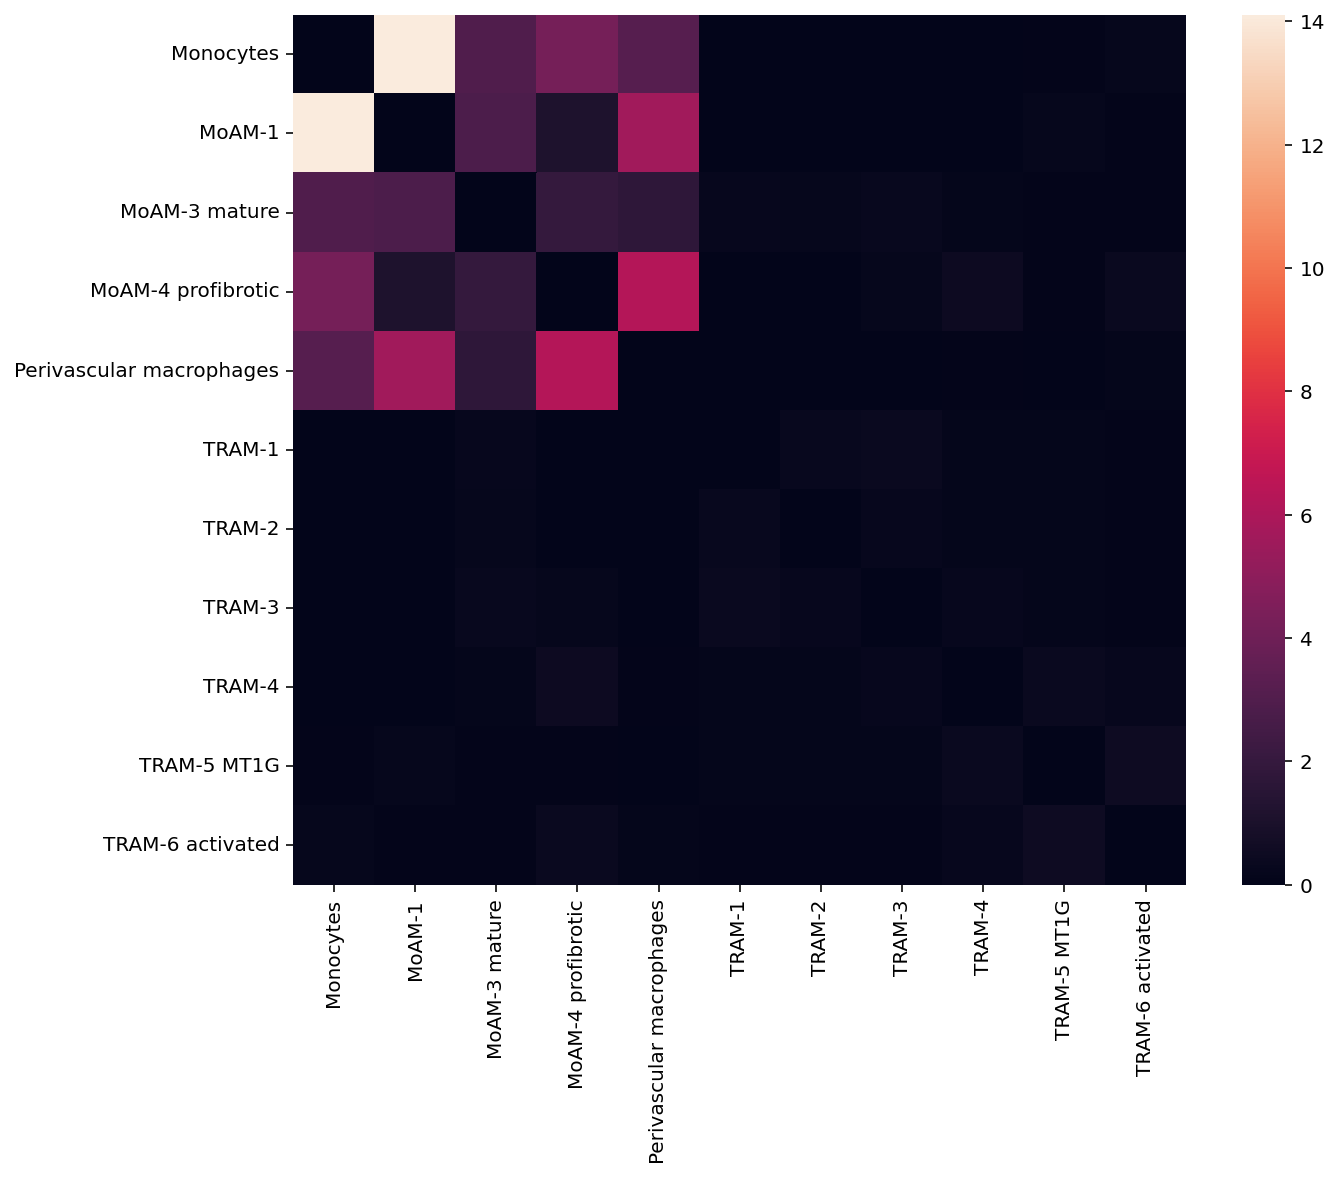

In [55]:
conn_hc = pd.DataFrame(
    myeloid_hc.uns["paga"]["connectivities"].todense(),
    index=myeloid_hc.obs.cell_type.cat.categories,
    columns=myeloid_hc.obs.cell_type.cat.categories,
)
sns.heatmap(conn_hc.loc[myeloid_order, myeloid_order])

### 3.6.2 PAGA connectivity for SSc without maximal clipping

In [56]:
c = myeloid_ssc.obs.cell_type.str.contains("MoAM|Mono|Peri", regex=True).sum()
print(f"Number of MoAMs, Monocytes and Perivascular macrophages: {c}")

Number of MoAMs, Monocytes and Perivascular macrophages: 25909


In [57]:
paga(myeloid_ssc, groups="cell_type")

<AxesSubplot:>

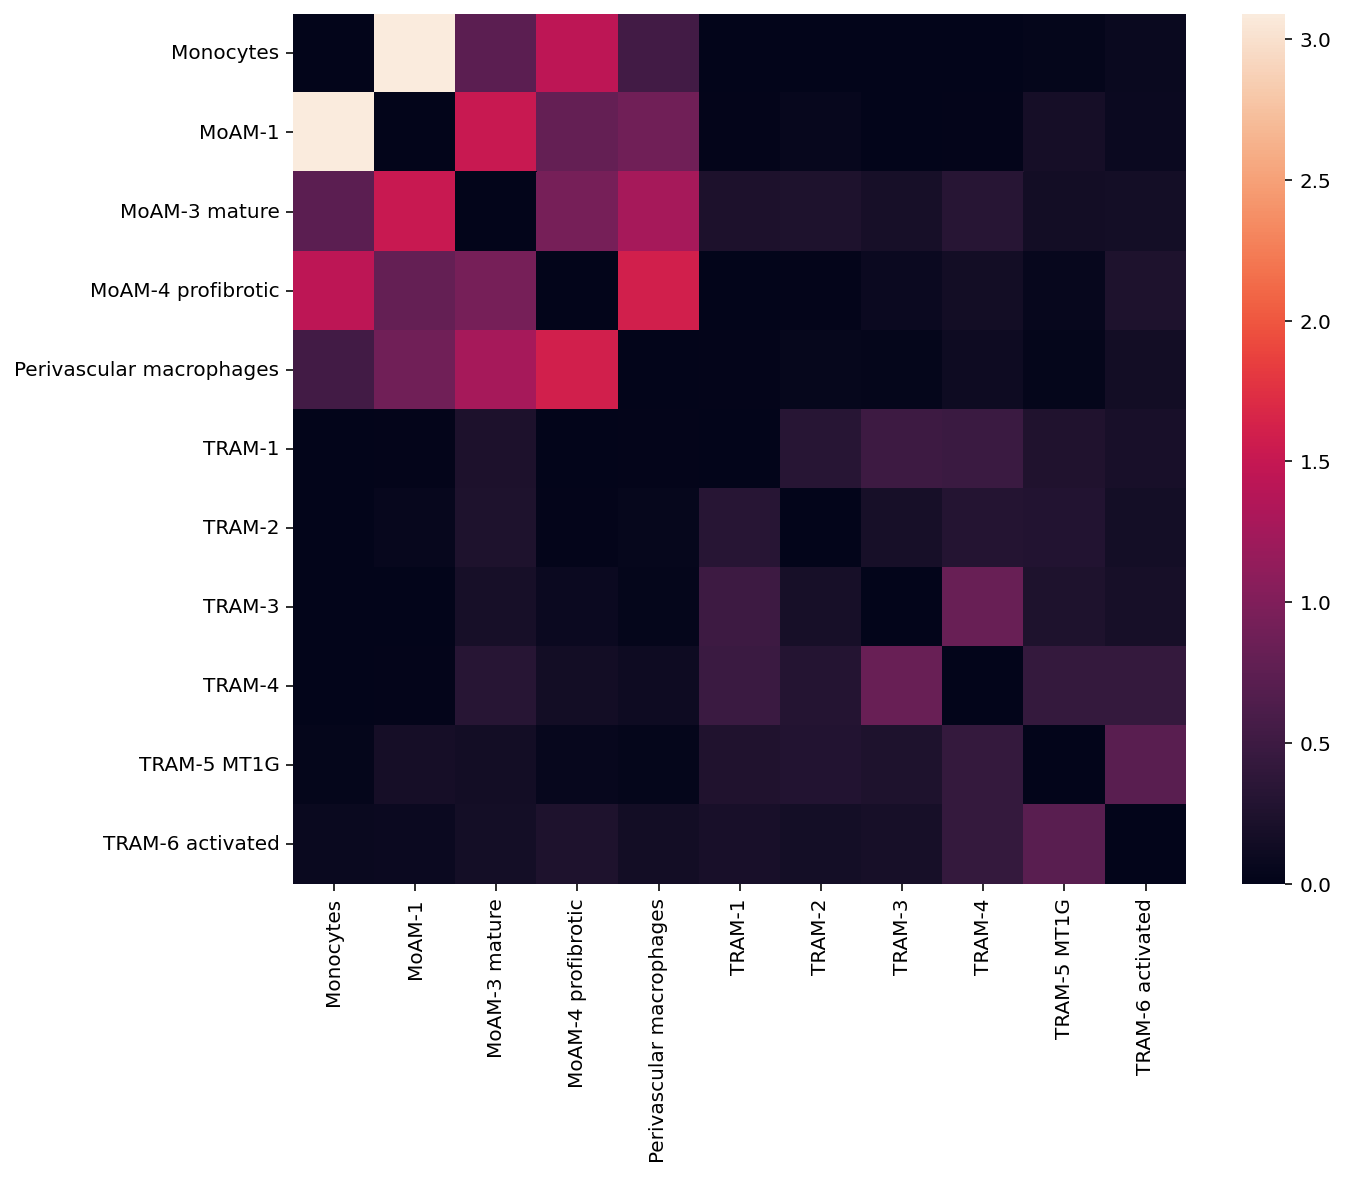

In [58]:
conn_ssc = pd.DataFrame(
    myeloid_ssc.uns["paga"]["connectivities"].todense(),
    index=myeloid_ssc.obs.cell_type.cat.categories,
    columns=myeloid_ssc.obs.cell_type.cat.categories,
)
sns.heatmap(conn_ssc.loc[myeloid_order, myeloid_order])

**Results**
1. It is possible to use this method to see inside MoAM interconnectivity
2. For HC the raw PAGA connectivity score between MoAMs is much higher: up to 14, compared to 3 in SSc. This is possibly due to fewer number of cells (10k vs 26k)
3. In HC and SSc both Monocytes are connected most strongly to MoAM-1, then MoAM-4 profibrotic
4. This suggests that our naming of MoAMs reflects their maturation
5. In SSc Perivascular macrophages are more tightly connected to MoAM-3 than in HC
6. Perivascular macrophages are highly connected to MoAM-4 profibrotic in both SSc and HC

# 4. Pseudotime and pseudotime differences between HC and SSc

## 4.1 Pseudotime starting from Monocytes

Let's start by looking at pseudotime transitions starting from Monocytes

### 4.1.1 In healthy controls

In [59]:
sc.tl.diffmap(myeloid_hc)

In [60]:
myeloid_hc.uns["iroot"] = np.flatnonzero(myeloid_hc.obs.cell_type.eq("Monocytes"))[100]

In [61]:
sc.tl.dpt(myeloid_hc)

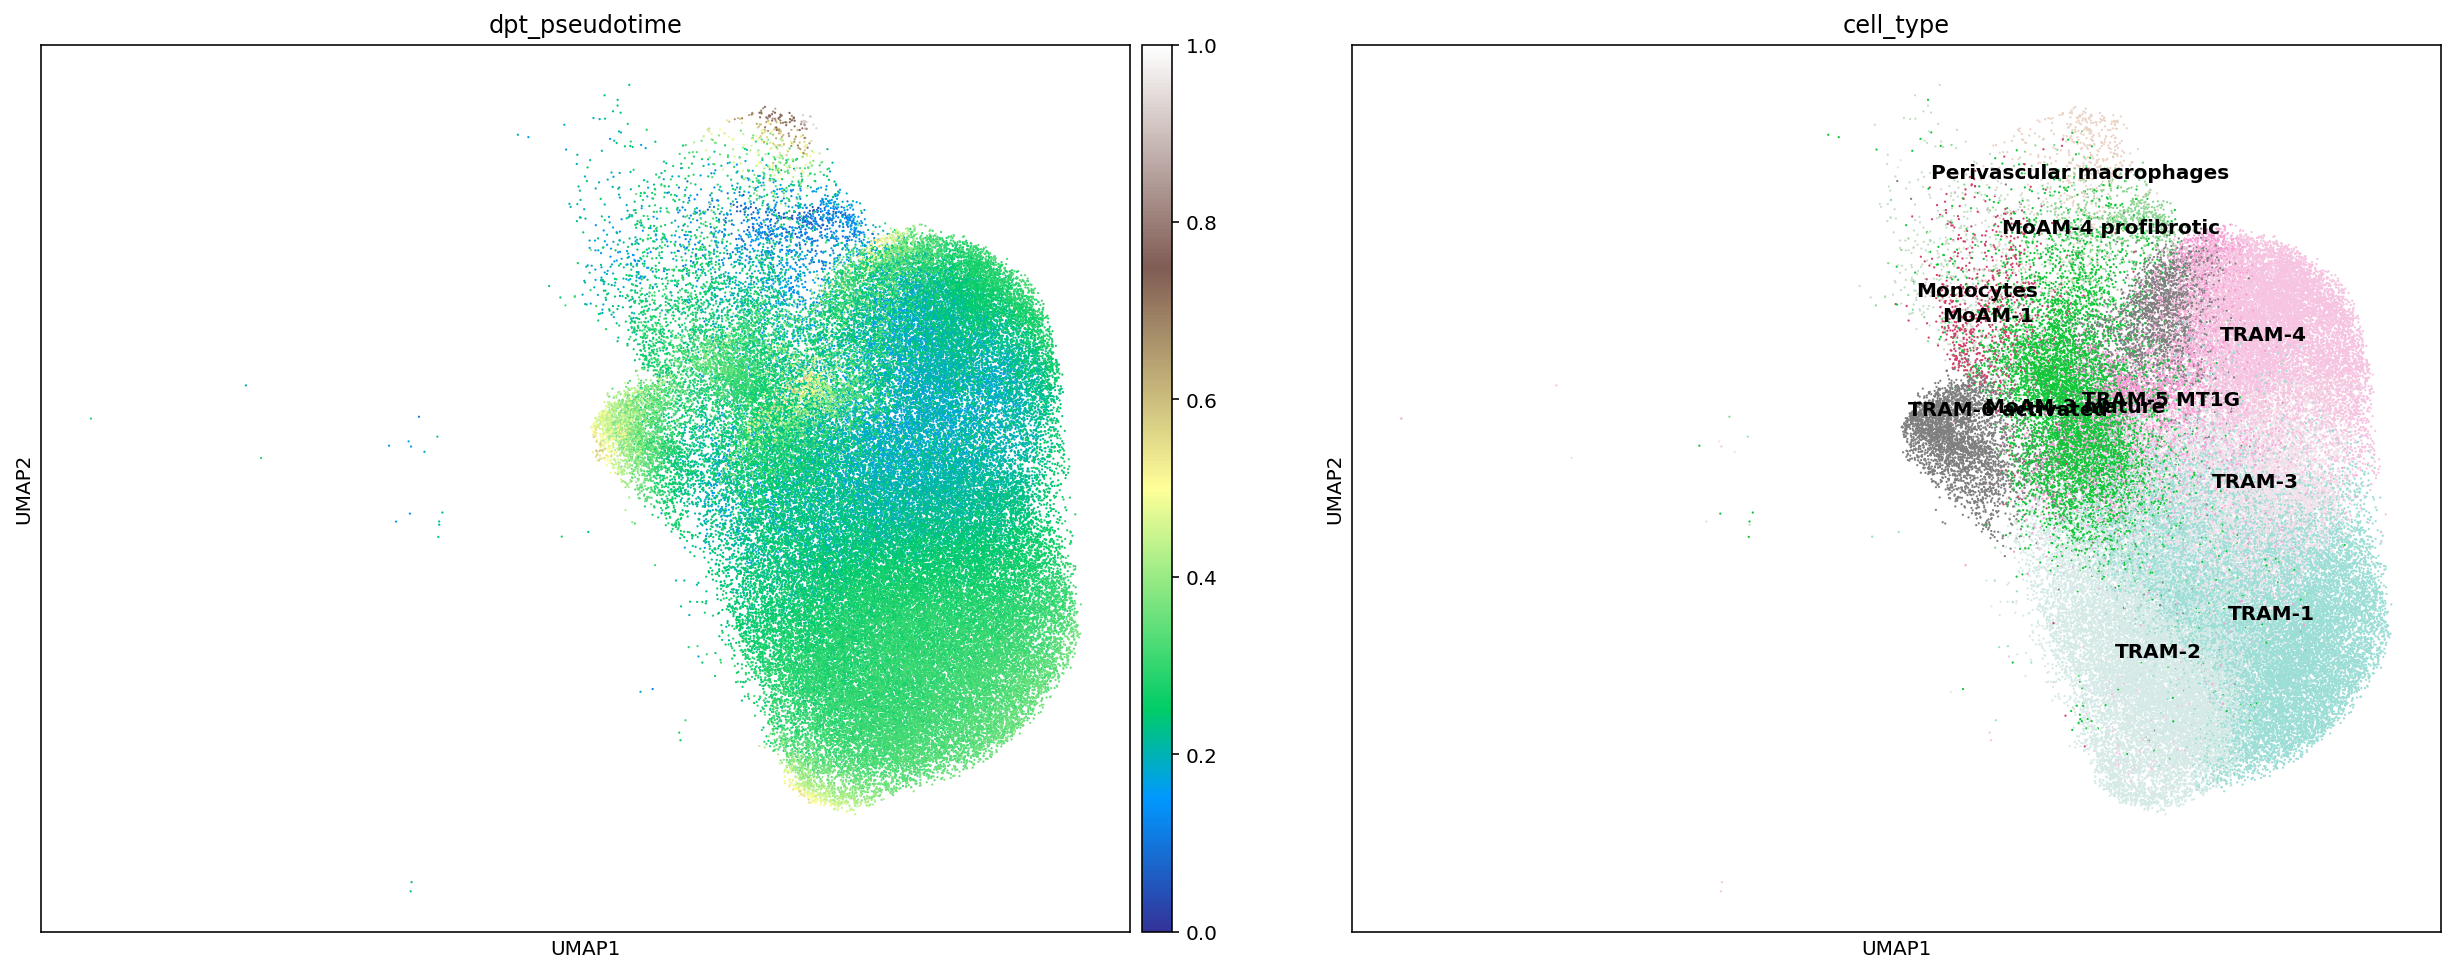

In [64]:
sc.pl.umap(myeloid_hc, color=["dpt_pseudotime", "cell_type"], cmap="terrain", legend_loc="on data", size=5)

As expected, Perivascular macrophages now occupy maximal pseudotime, and we can see a gradient of increasing pseudotime from MoAM to TRAM to TRAM-6 activated

### 4.1.2 In SSc

In [65]:
sc.tl.diffmap(myeloid_ssc)

In [66]:
myeloid_ssc.uns["iroot"] = np.flatnonzero(myeloid_ssc.obs.cell_type.eq("Monocytes"))[100]

In [67]:
sc.tl.dpt(myeloid_ssc)

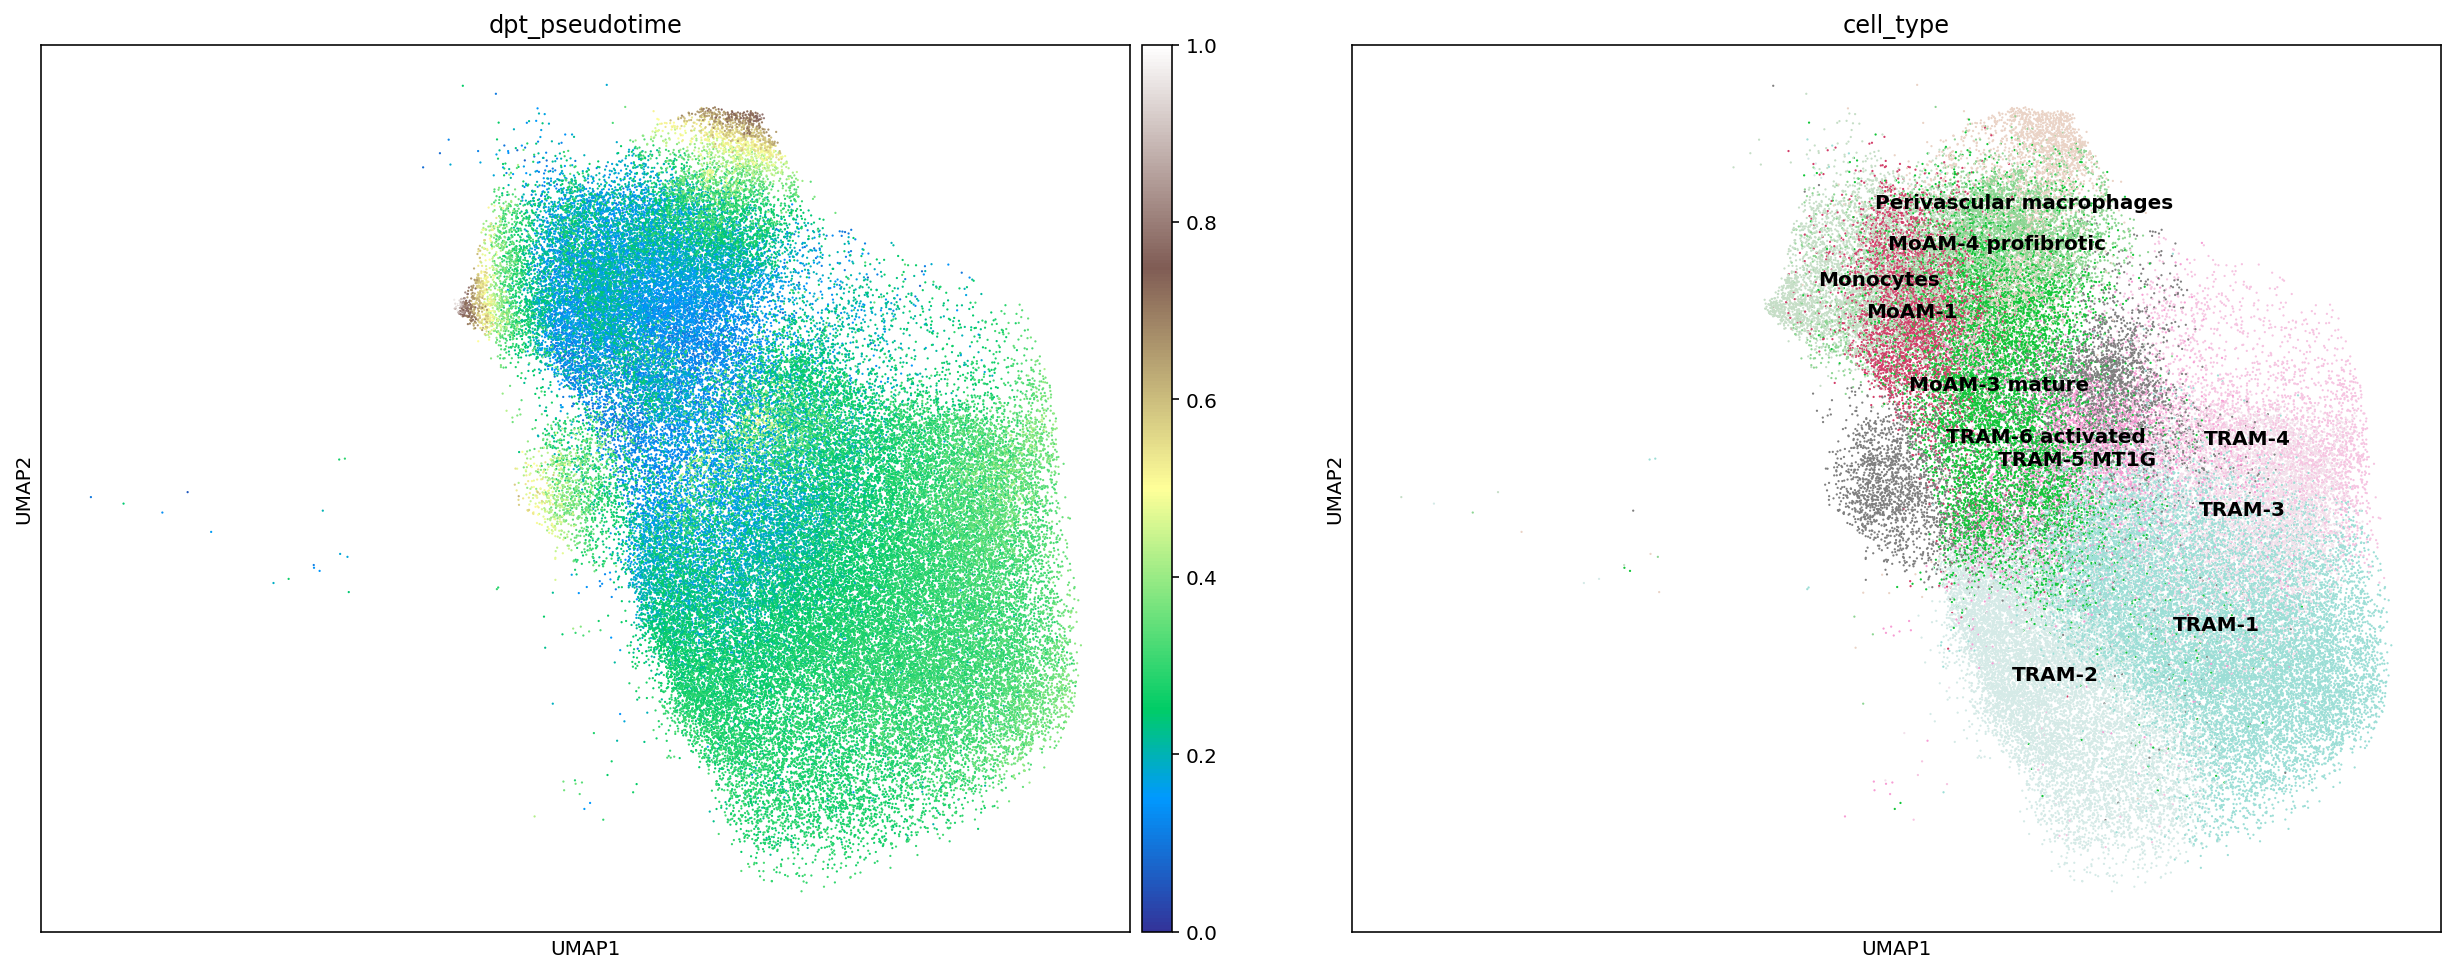

In [68]:
sc.pl.umap(myeloid_ssc, color=["dpt_pseudotime", "cell_type"], cmap="terrain", legend_loc="on data", size=5)

Monocytes seem to be more distant from the rest of the MoAMs and TRAMs in SSc compared to HC object. In both objects the most remote pseudotime is at Perivascular macrophages, suggesting their distinct origin.

**NB**: this is pseudotime computed from just 1 random Monocyte cell. We should sample several/many cells in Monocytes and compute the distribution of pseudotime values across cell types before using these in results.

Addressed comment from above: here we compute pseudotime for 400 randomly chosen Monocytes in HC and SSc separately, and compute average pseudotime for each cell, then we can assess the distribution of such average pseudotime per cell type.

In [70]:
CT = "Monocytes"
N = 400
rng = np.random.default_rng(1066)
result = {}
for obj in (myeloid_hc, myeloid_ssc):
    inits = rng.choice(np.flatnonzero(obj.obs.cell_type.eq(CT)), size=N, replace=False)
    mean_pseudotime = None
    for init in inits:
        obj.uns["iroot"] = init
        sc.tl.dpt(obj)
        if mean_pseudotime is None:
            mean_pseudotime = obj.obs.dpt_pseudotime.copy()
        else:
            mean_pseudotime += obj.obs.dpt_pseudotime
    result[obj.obs.Status.array[0]] = mean_pseudotime / N

In [71]:
df = pd.DataFrame(index=np.concatenate([myeloid_hc.obs_names, myeloid_ssc.obs_names]))
df.loc[myeloid_hc.obs_names, ["cell_type", "Status"]] = myeloid_hc.obs[["cell_type", "Status"]]
df.loc[myeloid_ssc.obs_names, ["cell_type", "Status"]] = myeloid_ssc.obs[["cell_type", "Status"]]
for _, pseudotime in result.items():
    df.loc[pseudotime.index, "pseudotime"] = pseudotime
df.cell_type = pd.Categorical(df.cell_type, categories=myeloid_order)
df.cell_type = df.cell_type.cat.remove_unused_categories()

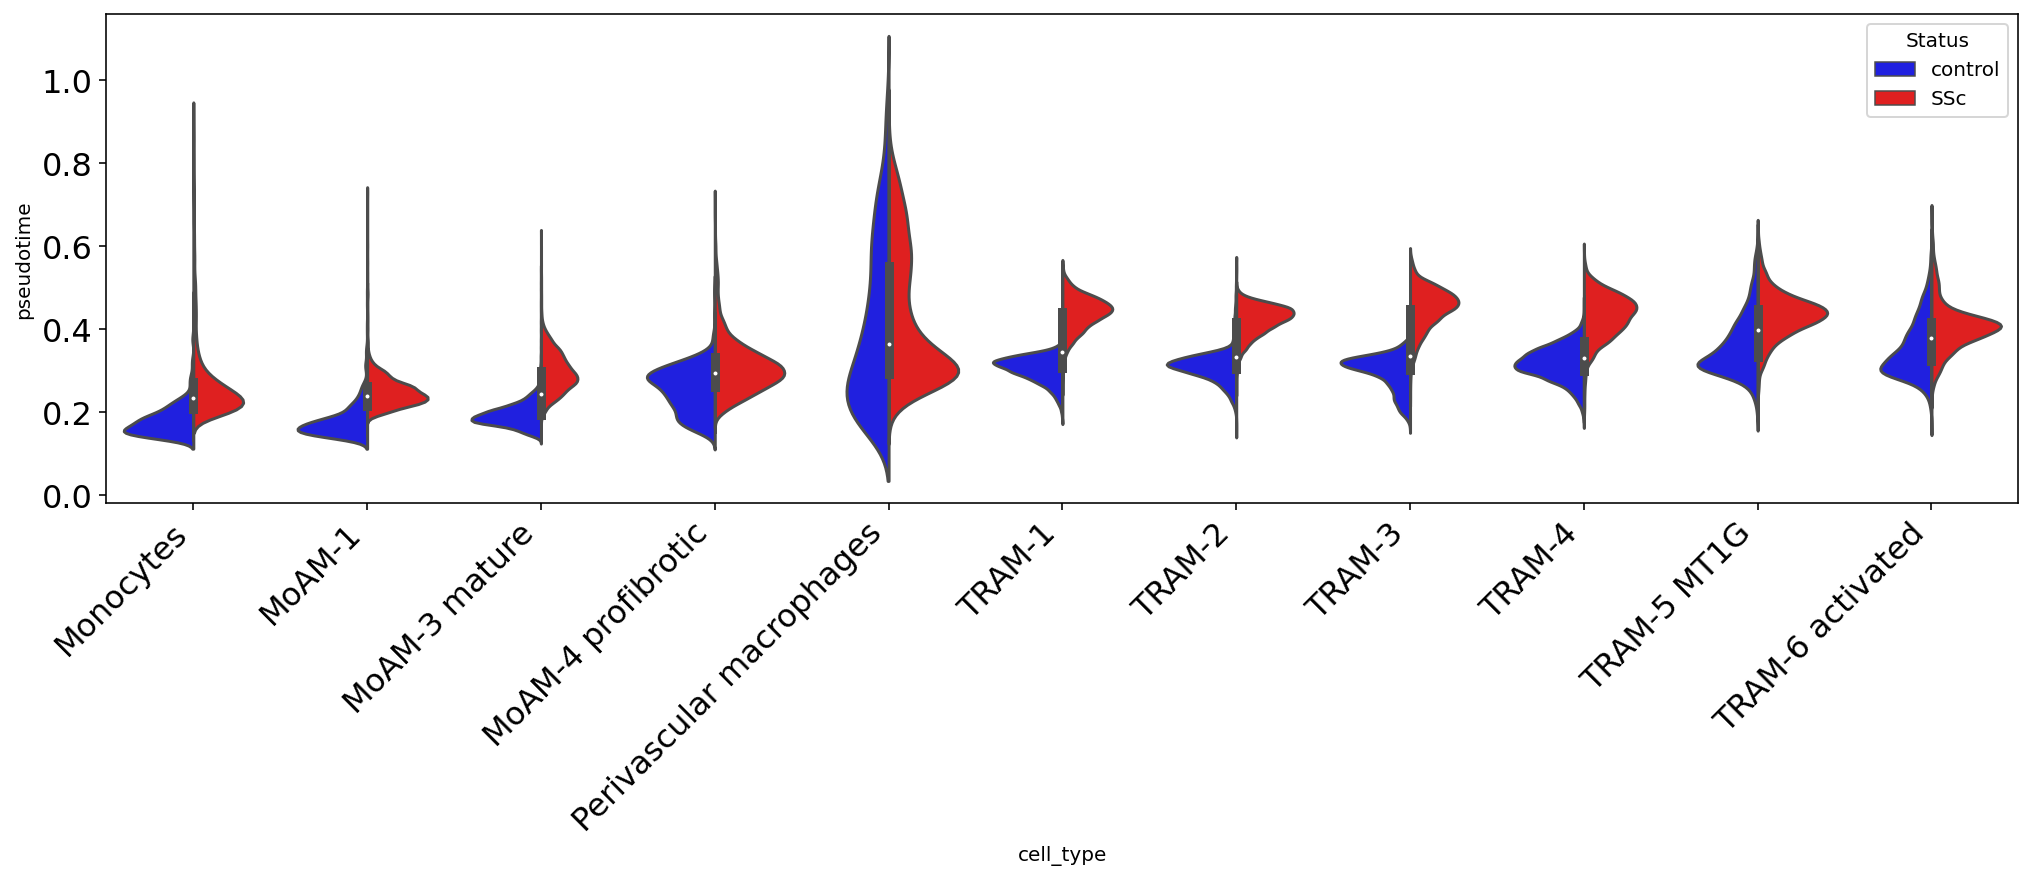

In [72]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
sns.violinplot(
    data=df, 
    x="cell_type", 
    y="pseudotime", 
    hue="Status", 
    split=True, 
    ax=ax, 
    show=False,
    palette=["blue", "red"]
)
ax.tick_params(axis="x", rotation=45, labelsize=16)
[t.set_ha("right") for t in ax.xaxis.get_ticklabels()]
ax.tick_params(axis="y", labelsize=16)

Indeed, pseudotime for starting Monocytes is quite different between HC and SSc samples, which makes it harder to interpret all other pseudotime values.

This is also because for SSc we have many more Monocytes than for HC.

## 4.2 Pseudotime starting from MoAM-1

Next, let's look at pseudotime from MoAM-1 cluster, as Monocytes might be too remote.

Again, let's take a sample of 500 MoAM-1 random initial cells

In [76]:
CT = "MoAM-1"
N = 500
rng = np.random.default_rng(1066)
result = {}
for obj in (myeloid_hc, myeloid_ssc):
    inits = rng.choice(np.flatnonzero(obj.obs.cell_type.eq(CT)), size=N, replace=False)
    mean_pseudotime = None
    for init in inits:
        obj.uns["iroot"] = init
        sc.tl.dpt(obj)
        if mean_pseudotime is None:
            mean_pseudotime = obj.obs.dpt_pseudotime.copy()
        else:
            mean_pseudotime += obj.obs.dpt_pseudotime
    result[obj.obs.Status.array[0]] = mean_pseudotime / N

In [77]:
df = pd.DataFrame(index=np.concatenate([myeloid_hc.obs_names, myeloid_ssc.obs_names]))
df.loc[myeloid_hc.obs_names, ["cell_type", "Status"]] = myeloid_hc.obs[["cell_type", "Status"]]
df.loc[myeloid_ssc.obs_names, ["cell_type", "Status"]] = myeloid_ssc.obs[["cell_type", "Status"]]
for _, pseudotime in result.items():
    df.loc[pseudotime.index, "pseudotime"] = pseudotime
df.cell_type = pd.Categorical(df.cell_type, categories=myeloid_order)
df.cell_type = df.cell_type.cat.remove_unused_categories()

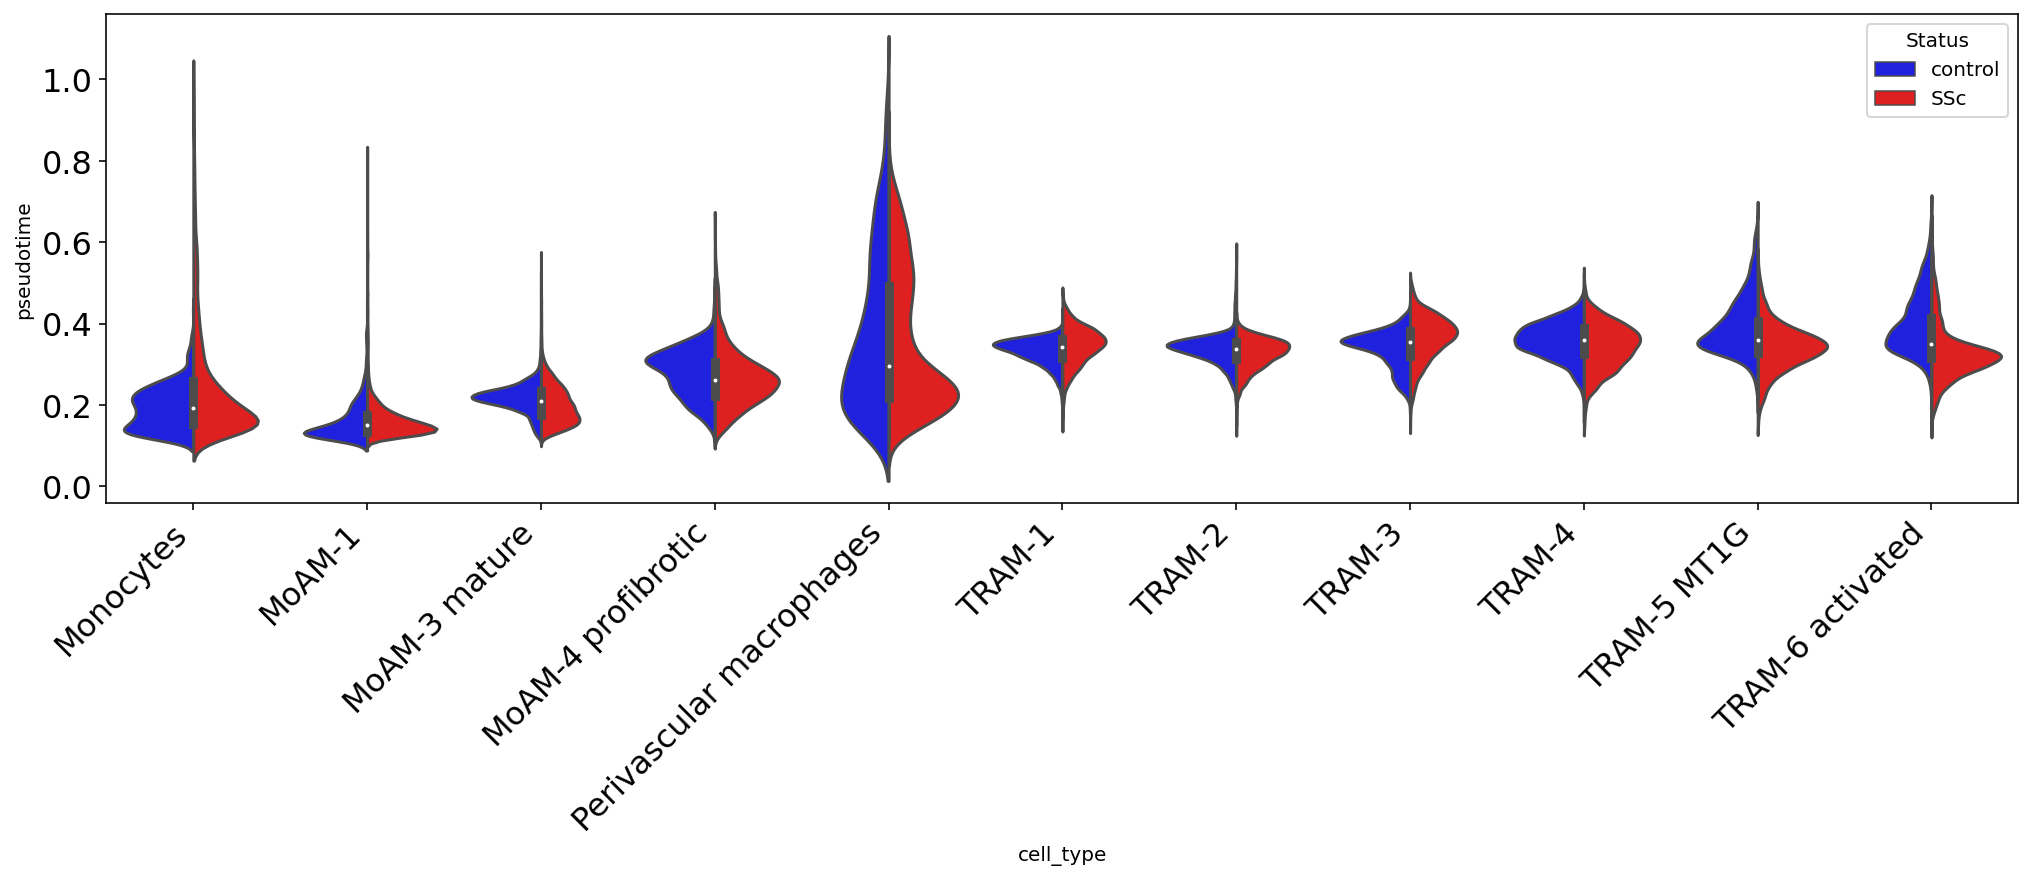

In [78]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
sns.violinplot(
    data=df, 
    x="cell_type", 
    y="pseudotime", 
    hue="Status", 
    split=True, 
    ax=ax, 
    show=False,
    palette=["blue", "red"]
)
ax.tick_params(axis="x", rotation=45, labelsize=16)
[t.set_ha("right") for t in ax.xaxis.get_ticklabels()]
ax.tick_params(axis="y", labelsize=16)

Great, here distribution of Pseudotime for MoAM-1 is almost equal between Controls and SSc.

This means we can compare distances for other cell types.

**Results & Interpretation**:
1. Distance to Monocytes is approximately equal for HC and SSc cells. In HC the distance is a bit bimodal, in SSc it is much wider.
2. Distance to MoAM-3 is a bit shorter in SSc than in HC
3. Distance to MoAM-4 profibrotic is a bit shorter in SSc compared to HC
4. Distance to Perivascular macrophages is wide, and higher in HC compared with SSc. It is the widest distance among the cell types, and a bit wider in HC. This suggests that part of that cluster is most distinct from other cells (MoAM-1) and that it has most “elongated” differentiation within it.
5. Distance to Perivascular macrophages is highest for both conditions. This suggests their distinct transcriptional profile and differentiation lineage.
6. Distance to TRAM-5 and TRAM-6 is higher in HC compared to SSc. This could be explained by more active recruitment and differentiation of monocytes in SSc, leading to TRAMs being closer in pseudotime space. In contrast, under homeostasis TRAMs are more different, suggesting slower process of differentiation.

## 4.3 Pseudotime starting from MoAM-3 mature

In [79]:
CT = "MoAM-3 mature"
N = 2000
rng = np.random.default_rng(1066)
result = {}
for obj in (myeloid_hc, myeloid_ssc):
    inits = rng.choice(np.flatnonzero(obj.obs.cell_type.eq(CT)), size=N, replace=False)
    mean_pseudotime = None
    for init in inits:
        obj.uns["iroot"] = init
        sc.tl.dpt(obj)
        if mean_pseudotime is None:
            mean_pseudotime = obj.obs.dpt_pseudotime.copy()
        else:
            mean_pseudotime += obj.obs.dpt_pseudotime
    result[obj.obs.Status.array[0]] = mean_pseudotime / N

In [80]:
df = pd.DataFrame(index=np.concatenate([myeloid_hc.obs_names, myeloid_ssc.obs_names]))
df.loc[myeloid_hc.obs_names, ["cell_type", "Status"]] = myeloid_hc.obs[["cell_type", "Status"]]
df.loc[myeloid_ssc.obs_names, ["cell_type", "Status"]] = myeloid_ssc.obs[["cell_type", "Status"]]
for _, pseudotime in result.items():
    df.loc[pseudotime.index, "pseudotime"] = pseudotime
df.cell_type = pd.Categorical(df.cell_type, categories=myeloid_order)
df.cell_type = df.cell_type.cat.remove_unused_categories()

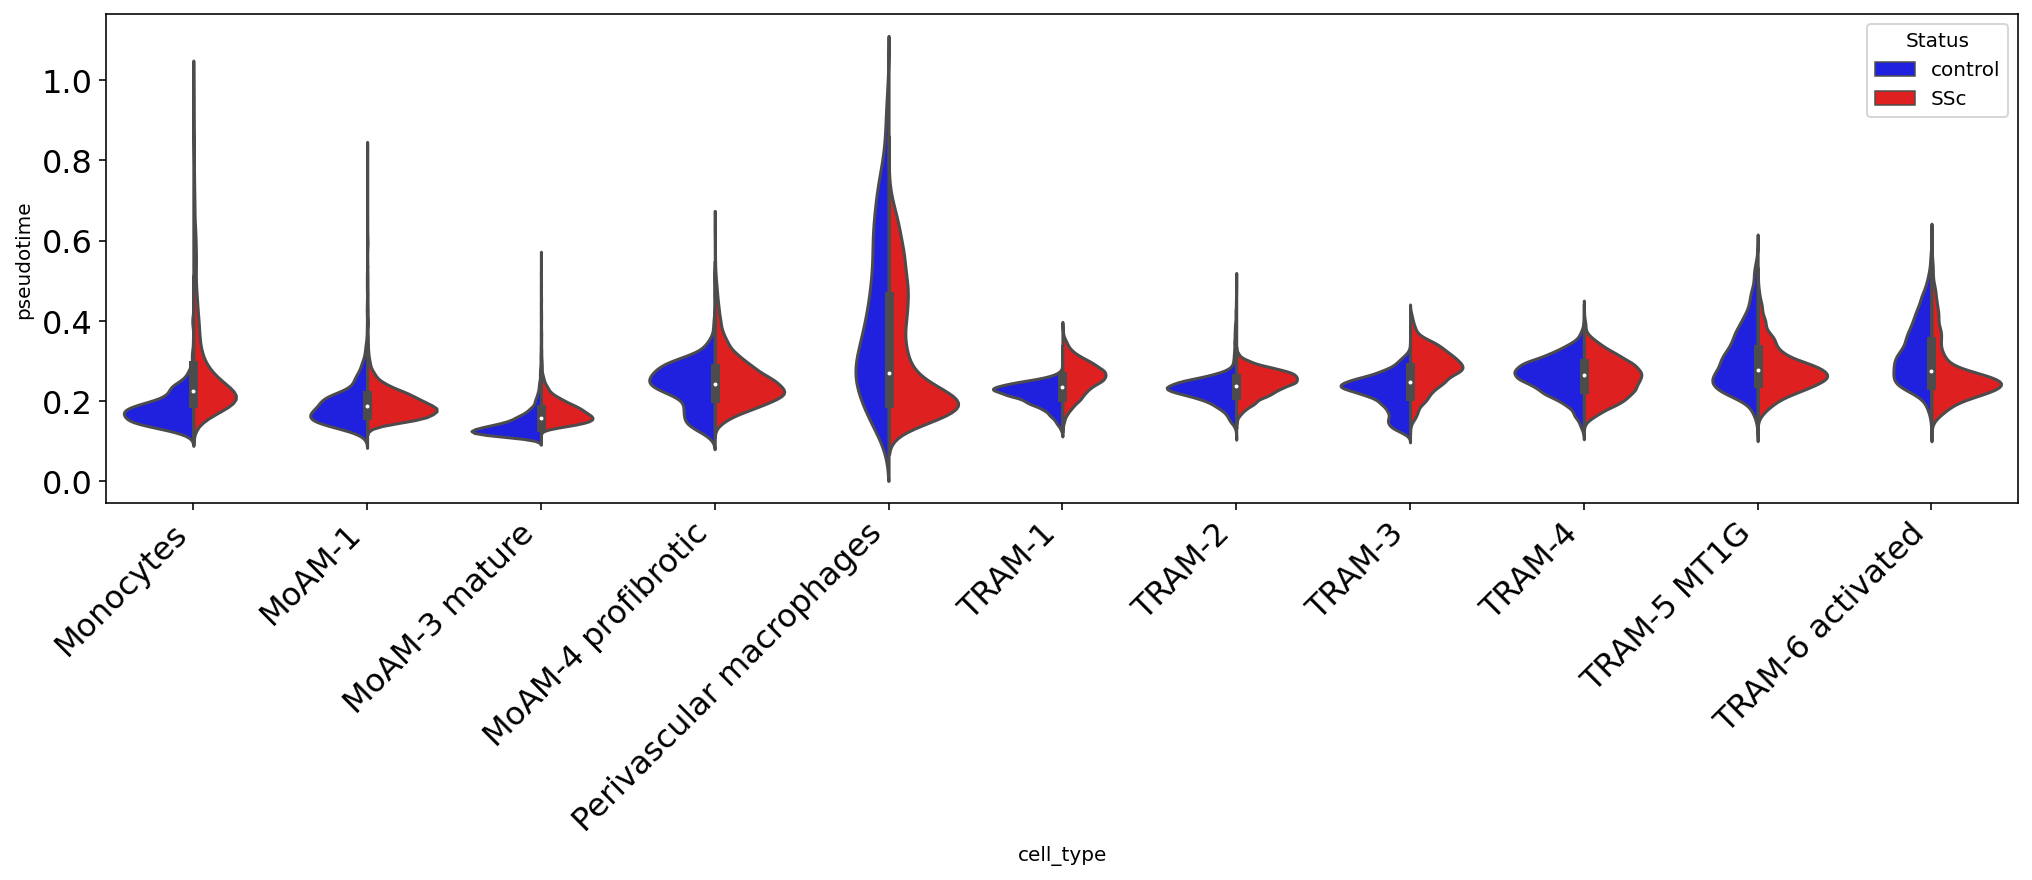

In [81]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
sns.violinplot(
    data=df, 
    x="cell_type", 
    y="pseudotime", 
    hue="Status", 
    split=True, 
    ax=ax, 
    show=False,
    palette=["blue", "red"]
)
ax.tick_params(axis="x", rotation=45, labelsize=16)
[t.set_ha("right") for t in ax.xaxis.get_ticklabels()]
ax.tick_params(axis="y", labelsize=16)

Here we cannot really compare pseudotime distribution, because MoAM-3 mature pseudotime between HC and SSc are different.

## 4.4 Pseudotime starting from MoAM-4 profibrotic

In [83]:
CT = "MoAM-4 profibrotic"
N = 500
rng = np.random.default_rng(1066)
result = {}
for obj in (myeloid_hc, myeloid_ssc):
    inits = rng.choice(np.flatnonzero(obj.obs.cell_type.eq(CT)), size=N, replace=False)
    mean_pseudotime = None
    for init in inits:
        obj.uns["iroot"] = init
        sc.tl.dpt(obj)
        if mean_pseudotime is None:
            mean_pseudotime = obj.obs.dpt_pseudotime.copy()
        else:
            mean_pseudotime += obj.obs.dpt_pseudotime
    result[obj.obs.Status.array[0]] = mean_pseudotime / N

In [84]:
df = pd.DataFrame(index=np.concatenate([myeloid_hc.obs_names, myeloid_ssc.obs_names]))
df.loc[myeloid_hc.obs_names, ["cell_type", "Status"]] = myeloid_hc.obs[["cell_type", "Status"]]
df.loc[myeloid_ssc.obs_names, ["cell_type", "Status"]] = myeloid_ssc.obs[["cell_type", "Status"]]
for _, pseudotime in result.items():
    df.loc[pseudotime.index, "pseudotime"] = pseudotime
df.cell_type = pd.Categorical(df.cell_type, categories=myeloid_order)
df.cell_type = df.cell_type.cat.remove_unused_categories()

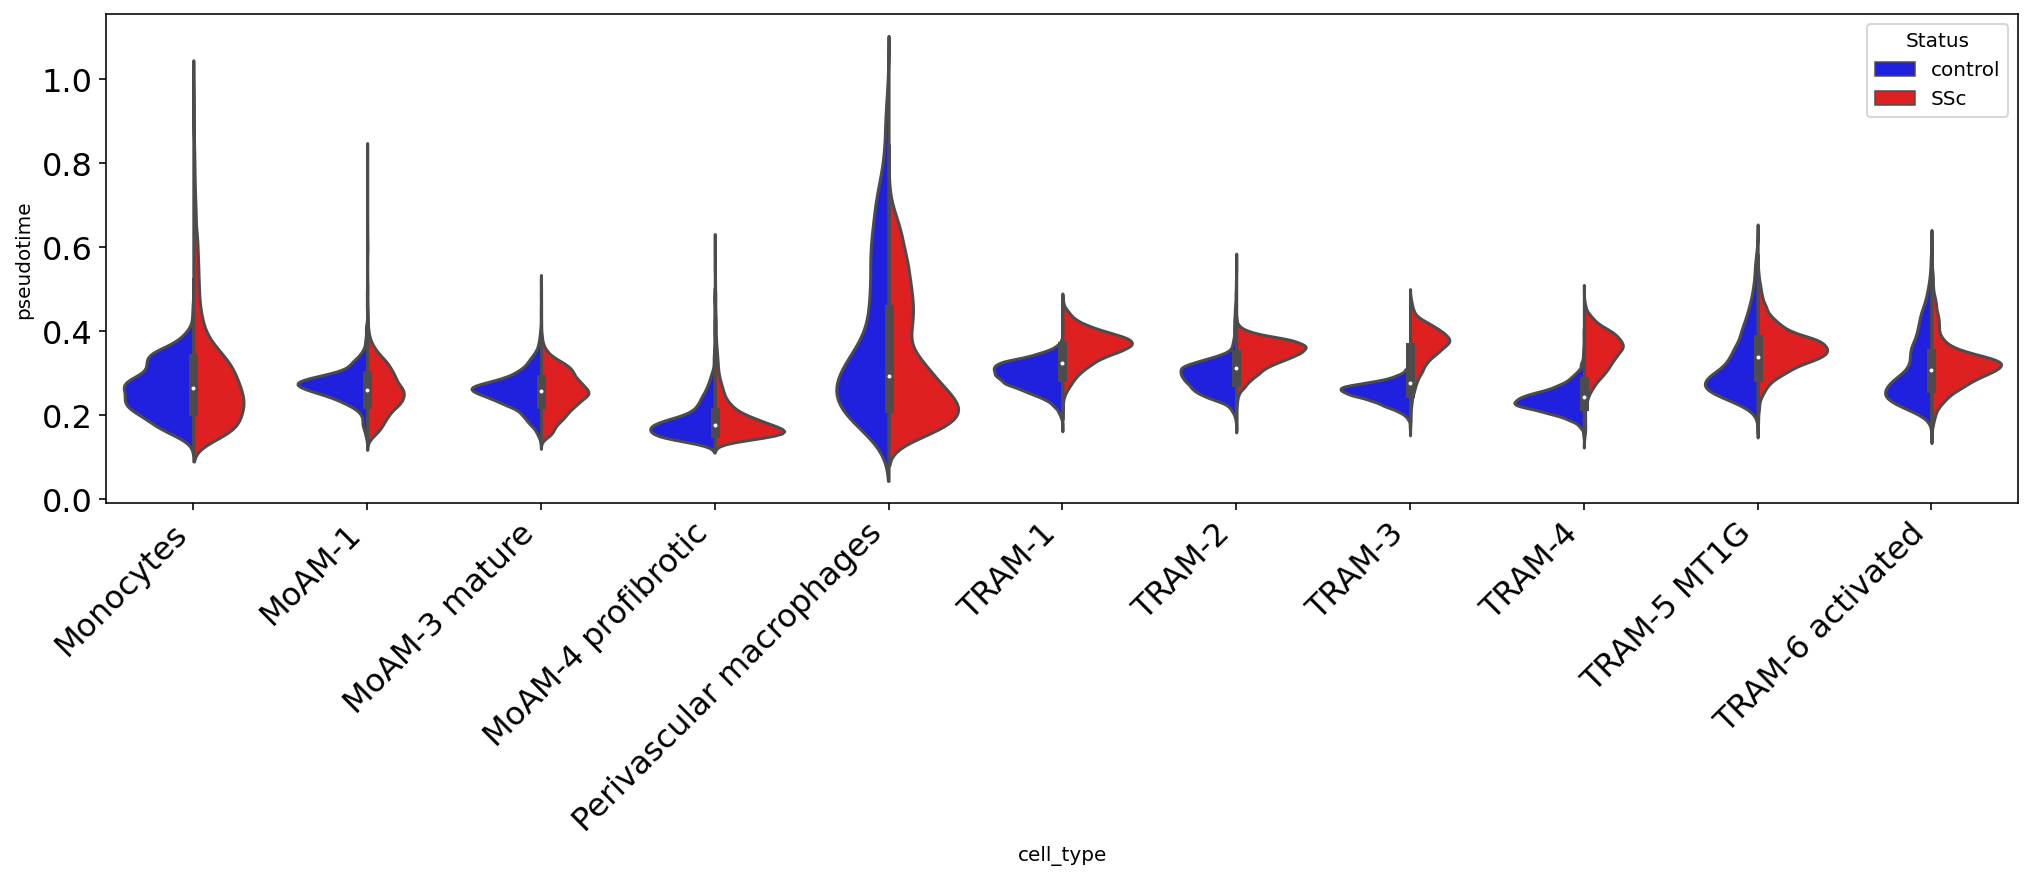

In [85]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
sns.violinplot(
    data=df, 
    x="cell_type", 
    y="pseudotime", 
    hue="Status", 
    split=True, 
    ax=ax, 
    show=False,
    palette=["blue", "red"]
)
ax.tick_params(axis="x", rotation=45, labelsize=16)
[t.set_ha("right") for t in ax.xaxis.get_ticklabels()]
ax.tick_params(axis="y", labelsize=16)

Here too the distribution of Pseudotime for MoAM-4 profibrotic is equal between Controls and SSc.

This means we can compare distances for other cell types.

**Results & Interpretation**:
1. Distances to TRAMs are higher in SSc than in HC for almost all TRAMs. This suggests that MoAM-4 profibrotic cells in HC are more closely related to TRAMs, and could be part of the slow replenishment process, which maybe is restricted to local microinjuries of the lung. In contrast, in SSc MoAM-4 profibrotic macrophages are more distinct from TRAMs, suggesting that they are different from their HC counterpart. **We will test this with pseudobulk analysis**.
2. Distance to Perivascular macrophages is wide and bimodal, and higher in HC compared with SSc. This is in agreement with previous analysis of pseudotime starting from `MoAM-1` cluster.

## 4.5 Explore Pseudotime plots

In [101]:
genes = """
FABP4
C1QA
INHBA
RBP4
MSR1
MRC1
FCN1
CD300E
G0S2
S100A12
CCR2
CCL2
C15orf48
VCAN
CCL3
CCL4
CCL20
CXCL10
CXCL8
SPP1
PLA2G7
MMP9
EMP1
EMP3
TREM2
CSF1
CSF1R
MT1G
CCL13
SEPP1
STAB1
SLC40A1
F13A1
MERTK
FOLR2
LILRB5
RNASE1
""".strip().split()

## 4.6 Pseudotime + PAGA plot

### 4.6.1 In Healthy controls

In [164]:
myeloid_hc_viz = myeloid_hc.raw.to_adata()

In [165]:
iroot_idx = myeloid_hc_viz.X[
    myeloid_hc_viz.obs.cell_type.eq('Monocytes')
][:, myeloid_hc_viz.var_names == 'FCN1'].argmax()

In [166]:
myeloid_hc_viz.uns["iroot"] = np.flatnonzero(myeloid_hc_viz.obs.cell_type.eq("Monocytes"))[iroot_idx]

In [167]:
sc.tl.dpt(myeloid_hc_viz)

In [168]:
myeloid_hc_viz = myeloid_hc_viz[:, genes].copy()

In [169]:
myeloid_hc_viz.X = myeloid_hc_viz.X.todense()

Remove 75% of TRAM-1 randomly for visualization

In [170]:
idx = myeloid_hc_viz.obs.cell_type.eq('TRAM-1')
rng = np.random.default_rng(1066)
to_remove = rng.choice(np.flatnonzero(idx), size=math.floor(idx.sum() * 0.75), replace=False)

In [171]:
to_remove = myeloid_hc_viz.obs_names[to_remove]

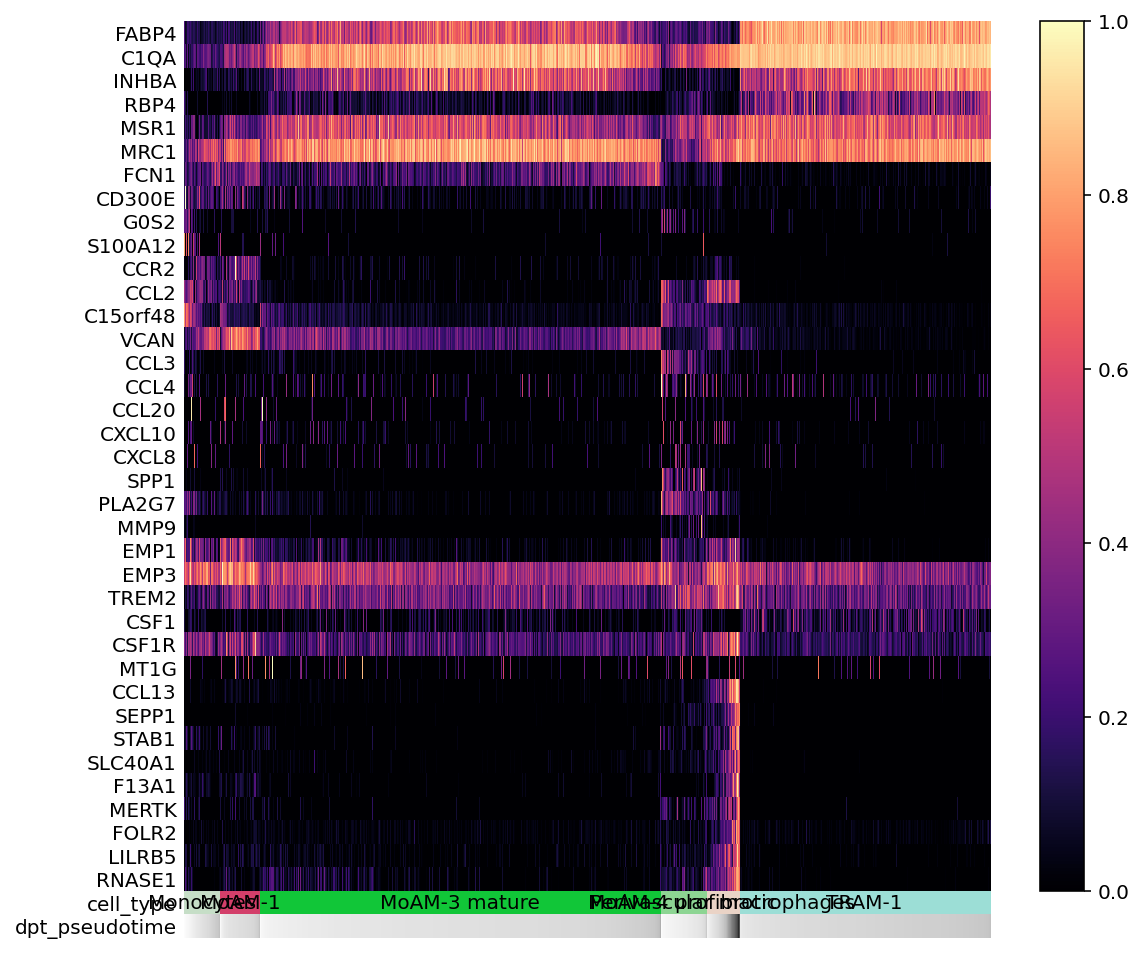

In [172]:
sc.pl.paga_path(
    myeloid_hc_viz[~myeloid_hc_viz.obs_names.isin(to_remove)], 
    nodes=myeloid_order[:-5], 
    keys=genes,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    color_map='magma'
)

In [184]:
myeloid_order[:-5]

['Monocytes',
 'MoAM-1',
 'MoAM-3 mature',
 'MoAM-4 profibrotic',
 'Perivascular macrophages',
 'TRAM-1']

### 4.6.2 In SSc

In [173]:
myeloid_ssc_viz = myeloid_ssc.raw.to_adata()

In [174]:
iroot_idx = myeloid_ssc_viz.X[
    myeloid_ssc_viz.obs.cell_type.eq('Monocytes')
][:, myeloid_ssc_viz.var_names == 'FCN1'].argmax()

In [175]:
myeloid_ssc_viz.uns["iroot"] = np.flatnonzero(myeloid_ssc_viz.obs.cell_type.eq("Monocytes"))[iroot_idx]

In [176]:
sc.tl.dpt(myeloid_ssc_viz)

In [177]:
myeloid_ssc_viz.raw = myeloid_ssc_viz

In [178]:
myeloid_ssc_viz = myeloid_ssc_viz[:, genes].copy()

In [179]:
myeloid_ssc_viz.X = myeloid_ssc_viz.X.todense()

Remove 50% of TRAM-1 randomly for visualization

In [180]:
idx = myeloid_ssc_viz.obs.cell_type.eq('TRAM-1')
rng = np.random.default_rng(1066)
to_remove = rng.choice(np.flatnonzero(idx), size=math.floor(idx.sum() * 0.5), replace=False)

In [181]:
to_remove = myeloid_ssc_viz.obs_names[to_remove]

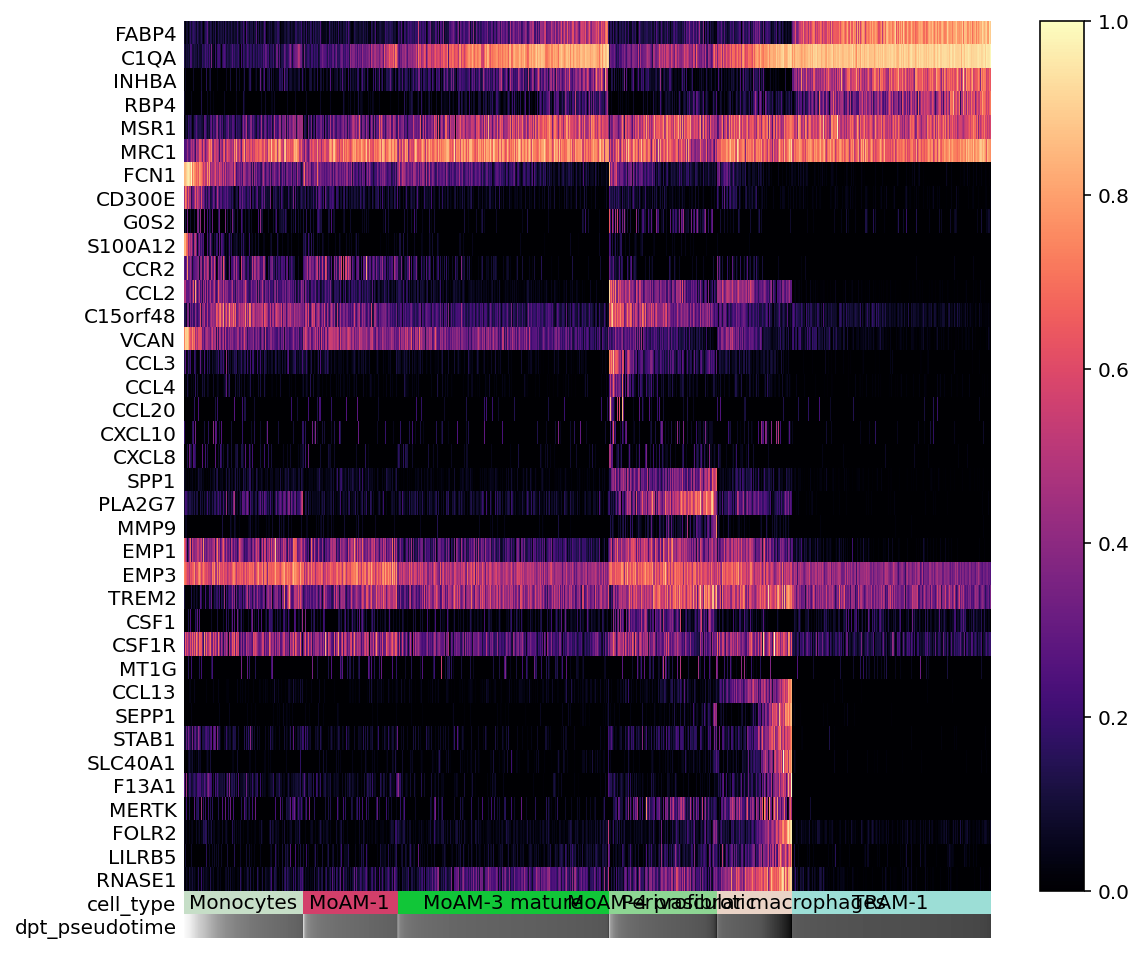

In [182]:
sc.pl.paga_path(
    myeloid_ssc_viz[~myeloid_ssc_viz.obs_names.isin(to_remove)], 
    nodes=myeloid_order[:-5], 
    keys=genes,
    use_raw=False,
    n_avg=10,
    normalize_to_zero_one=True,
    color_map='magma'
)

These are more reasonable plots.

**Conclusions**:
1. In SSc the branching point between Monocyte → MoAM-4 profibrotic and Monocyte → MoAM-3 mature trajectories seems to be somewhere inside Monocyte cluster, judging by expression of CCL2, C15orf48 and FCN1